# Music Generation RNN
This jupyter notebook covers the whole data pipeline and goes through multiple experiments to reflect on our achievements and learnings during the development process.

## Setup
This section installs and imports the required libraries.

In [5]:
!pip install pretty-midi
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
;

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
import src.models.basic_rnn
import src.utils.visualization
import imp
imp.reload(src.models.basic_rnn)
imp.reload(src.utils.visualization)
import src.models.basic_rnn as brnn
from src.utils.visualization import plot_piano_roll, plot_histories
from IPython.display import Image

# Best Results

The progression of our models are shown below in various experiments studies. We start off by highlighting some of our best output

# Overview of what is changing between experiments

## Input data

### Timing
Midi files can be processes in a number of ways. Midi files contain high fidelity information about what notes For our experiments we take the input and process it into 4/4 time. This means checking the midi file if each note is being play during the 16 beats per bar

1. Processing just the notes held
2. Notes held and articulation

### Model
How many different LSTM layers do we need?
1. 2 LSTM layers with X number of nodes
2. Trying model with 4 Nodes
3. Try GRU???

### Multi Input / Multi Output Considerations
1. Tried inputing all notes in, all notes out
2. Tried Note invariance where all notes are input across the batch direction

### Batch size
1. Small batch size
2. Large batch size

### Loss Types
1. RMSE
2. Categorical Cross Entropy

### Layer Activations
1. Sigmoid as we want to force binomial 
2. RELU and playing the top X notes??


### Predicting Notes
1. Inputing a single beat at a time
2. Inputing 3 beats and predicting the 4th
3. Inputing 15 beats and predicting the 16th
4. Inputing 31 beats and predicting the 32nd



## Experiments
Our data pre-processing is handled by the different experiment classes as some of them require differ inputs which we have continuosly improved during our research and development. 

### Experiment 1 - Tensorflow Tutorial
The modle provided by the Tensorflow tutorial is very different from the other models and the model in the paper by Daniel Johnson because it does not use the a beat-wise structure. Instead it utilizes the time stamps of each note. While this simplifies the data processing, the generated music is not very complex. Link to model: https://www.tensorflow.org/tutorials/audio/music_generation

- Input: The data is in a dictonary of the form \["pitch", "step", "duration"\]
- Model: 1 LSTM layer (128) and one Dense layer without activation. 
    - Optimizer: Adam
    - Loss: SparseCategoricalLoss
- Output: Predicts pitch, step, and duration at the same time

### Experiment 1 - Multi Input Multi Output

- Input: The data is in shape (260 x seq_length) - 260 being 128 notes + 128 articulations + 4 beats
- Model: 4 LSTM layers (256) and one Dense layer without relu activation. 
    - Optimizer: Adam
    - Loss: CategoricalCrossEntropy
- Output: Predicts the next timesteps, i.e. which notes are played at the next beat. 256


### Analysis

This model fails to train and learn anything useful. The major difference between this model and future models is that the output of this network are all 128 notes and 128 articulations. Most of these values will be zero most of the time. It is likely that training such a sparse model plays into why we didn't see reasonable results with this model.

This model is improved on in future models below:

In [6]:
print("Experiment 1:")
exp1 = brnn.RNNMusicExperimentOne(
    learning_rate=0.0001,
    epochs=3,
    batch_size=64,
    num_music_files=2,
    sequence_length=15,
)
exp1.set_model()
loaded_data = exp1.load_data()
prepared_data = exp1.prepare_data(loaded_data)
print("Training...")
model, history = exp1.train_model(prepared_data)

Experiment 1:
in get model
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 15, 260)]         0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 15, 256)           529408    
_________________________________________________________________
lstm_17 (LSTM)               (None, 15, 256)           525312    
_________________________________________________________________
lstm_18 (LSTM)               (None, 15, 256)           525312    
_________________________________________________________________
lstm_19 (LSTM)               (None, 256)               525312    
_________________________________________________________________
pitch (Dense)                (None, 256)               65792     
Total params: 2,171,136
Trainable params: 2,171,136
Non-trainable params: 0
______________________

### Experiment 2 - Limited connectivity multi input multi output 

This model builds on the previous model by using custom LSTM kerenl regularizer to ensure that the output of one note only get a limited view of the input notes.

This was done to model the previous vincinity that the original authors proposed


### Analysis

Adding the limited connectivity did not deal with the shortcomings of this model

In [13]:
print("Experiment 2")
exp2 = brnn.RNNMusicExperimentTwo(
    sequence_length=15,
    learning_rate=0.001,
    epochs=5,
)
exp2.set_model()
loaded_data = exp2.load_data()
prepared_data = exp2.prepare_data(loaded_data)
print("Training...")
model, history = exp2.train_model(prepared_data)

Experiment 2
tst all_song_dfs.shape in is (4572, 256)
all_song_dfs.shape in is (4572, 260)
sequences.shape is (16, 260)
X_tst.shape out is (15, 260)
y_tst.shape out is (15, 260)
Training...
type prepared_data is <class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
Epoch 1/5
260 1024
(260, 1024)
(1024, 260)
256 1024
260 1024
(260, 1024)
(1024, 260)
256 1024
71/71 [==============================] - 5s 11ms/step - loss: 377.9346
Epoch 2/5
71/71 [==============================] - 1s 9ms/step - loss: 37.4899
Epoch 3/5
71/71 [==============================] - 1s 9ms/step - loss: 42.4700
Epoch 4/5
71/71 [==============================] - 1s 9ms/step - loss: 53.0249
Epoch 5/5
71/71 [==============================] - 1s 9ms/step - loss: 63.5412


## Experiment: Affect of adding extra information for predicting

In this experiment we compare two models that include just the vicinity notes vs vicinity plus "extras"


Here "extras" refers to
- Midi ref note
- pitch class ref note
- pitch counts across octaves

In [24]:
print("Experiment 3")
exp3 = brnn.RNNMusicExperimentThree(
    learning_rate=0.01,
    epochs=3,
    batch_size=1,
    num_music_files=1,
)
exp3.run()
exp3.predict_and_save_data("_justnotes_")

exp4 = brnn.RNNMusicExperimentFour(
    learning_rate=0.01,
    epochs=3,
    batch_size=1,
    num_music_files=1,
)
exp4.run()
exp4.predict_and_save_data("_other_information_")

Experiment 3
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 128, 50)           15800     
_________________________________________________________________
lstm_25 (LSTM)               (None, 128, 50)           20200     
_________________________________________________________________
lstm_26 (LSTM)               (None, 128, 50)           20200     
_________________________________________________________________
dense_8 (Dense)              (None, 128, 2)            102       
Total params: 56,302
Trainable params: 56,302
Non-trainable params: 0
_________________________________________________________________
Training...
Epoch 1/3
1823/1823 [==============================] - 21s 10ms/step - loss: 0.0565 - mse: 0.0113
Epoch 2/3
1823/1823 [==============================] - 18s 10ms/step - loss: 0.0346 - mse: 0.0069
Epoch 3/3
1823/1823 [======

AttributeError: 'RNNMusicExperimentThree' object has no attribute 'predict_and_save_data'

## Experiment: Affect of predicting using more or less beats in time

This is a note invariant model
- Trained using one song
- All 128 notes are input across the batch dimension
- The song time dimension is input into the LSTM tiime dimension


## Analysis of number of beats used for prediction

The understanding of performance difference for using a different number of beats is best heard rather than seen. The differences in results can be heard at this YOUTUBE_LINK

However the plots below show some insight. The plots show using (1 neat, 3 beats, 15 beats, and 31 beats) in that order. It can be seen that the single beat appears to be the most random. This is also heard in the respective audio files. This makes sense as the neural network isn't able to retain useful musical memory in it's internal state.

In [11]:
 print("Trying Exp 5")
exp = brnn.RNNMusicExperimentFive(
    learning_rate=0.01,
    epochs=3,
    batch_size=1,
    num_music_files=1)
exp.run()

print("Exp 5 predicting with 31 beats")
exp.common_config["num_beats_for_prediction"] = 31
exp.predict_and_save_data("_31beats_")

print("Exp 5 predicting with 15 beats")
exp.common_config["num_beats_for_prediction"] = 15
exp.predict_and_save_data("_15beats_")

print("Exp 5 predicting with 3 beats")
exp.common_config["num_beats_for_prediction"] = 3
exp.predict_and_save_data("_3beats_")

Trying Exp 5
in get_model self is <src.models.basic_rnn.RNNMusicExperimentFive object at 0x7f47d0470668>
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 128, 50)           20800     
_________________________________________________________________
lstm_16 (LSTM)               (None, 128, 50)           20200     
_________________________________________________________________
lstm_17 (LSTM)               (None, 128, 50)           20200     
_________________________________________________________________
dense_5 (Dense)              (None, 128, 2)            102       
Total params: 61,302
Trainable params: 61,302
Non-trainable params: 0
_________________________________________________________________


/home/ecbm4040/envTF24/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Training...
Epoch 1/3
1206/1206 [==============================] - 15s 10ms/step - loss: 0.0680 - mse: 0.0157
Epoch 2/3
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0419 - mse: 0.0106
Epoch 3/3
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0390 - mse: 0.0098
Predicting data...
Saving data...
Exp 5 predicting with 31 beats
Predicting data...
Saving data...
Exp 5 predicting with 15 beats
Predicting data...
Saving data...
Exp 5 predicting with 3 beats
Predicting data...
Saving data...


### Predicting using 1 beats

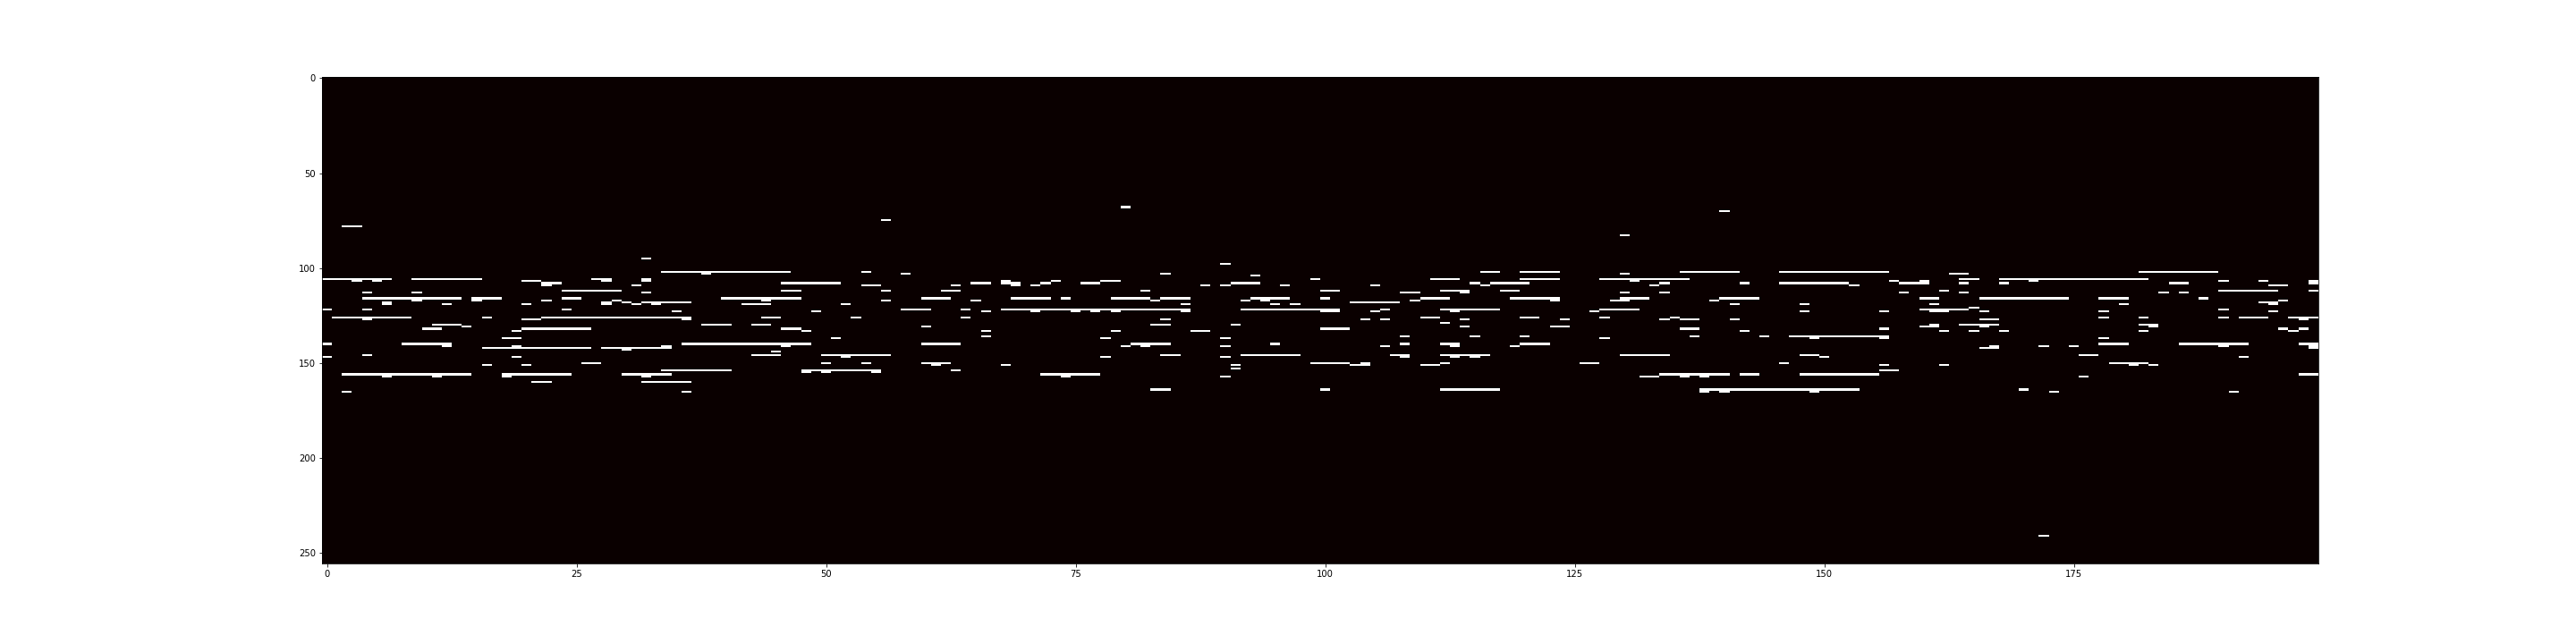

In [13]:
Image("plots/Exp5_both__predicted_15_0dot01_3_1_1_128_1__12-21-2021_17-35-26.png")

### Predicting using 3 beats

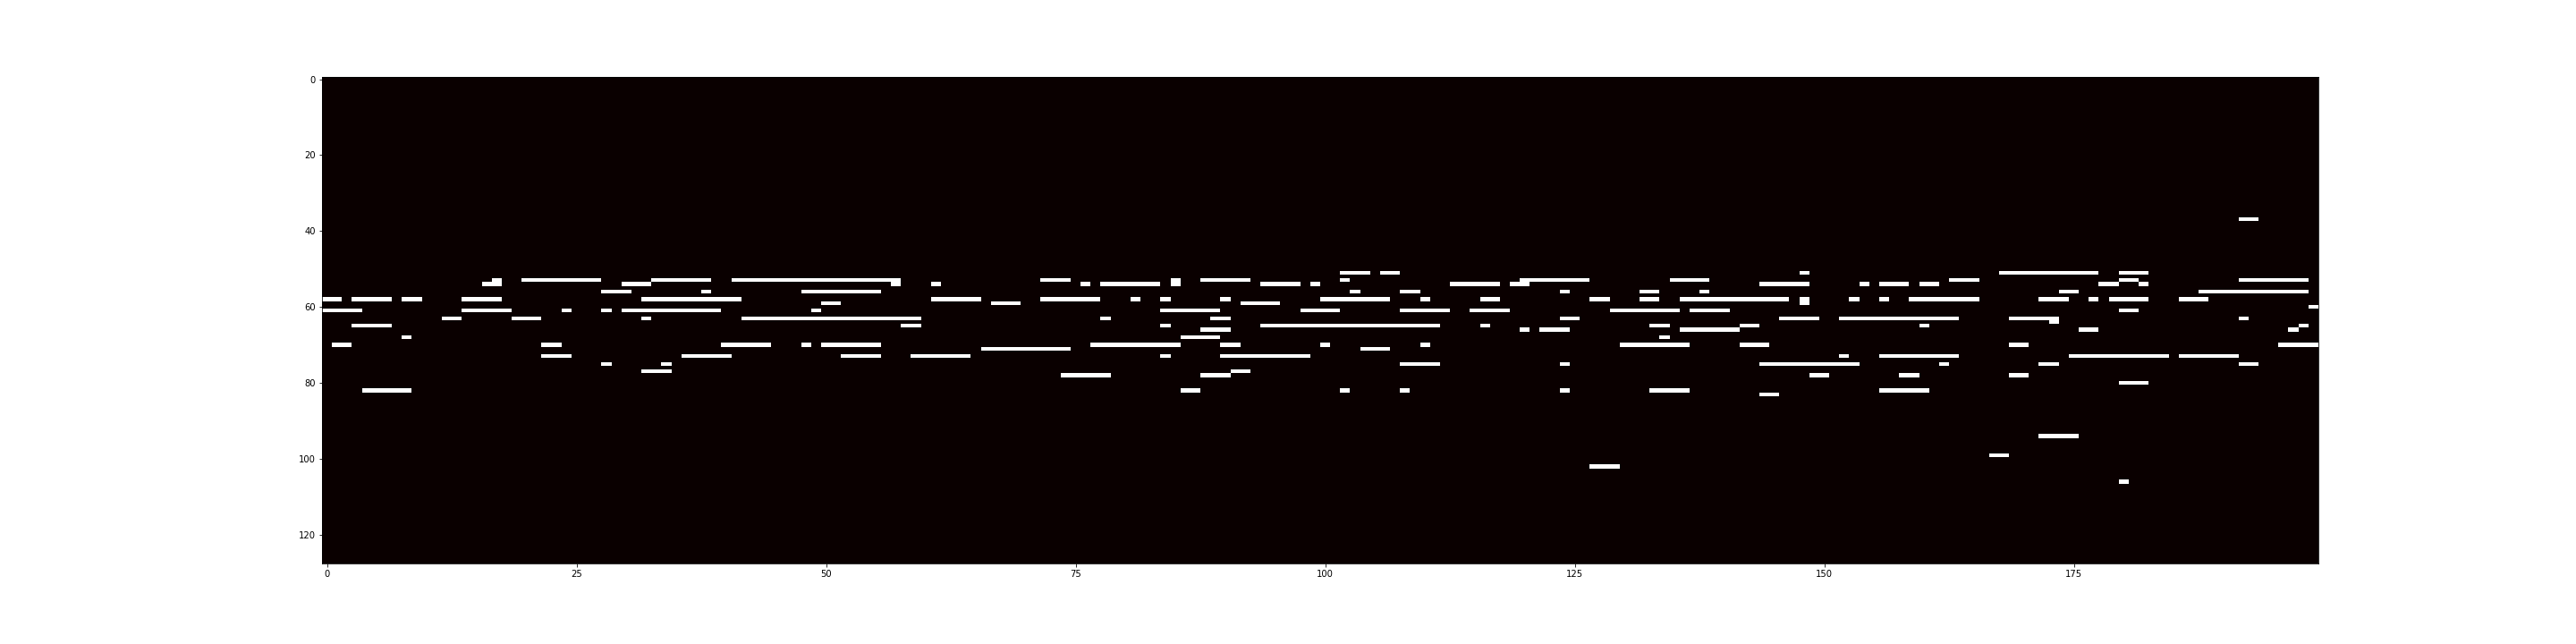

In [15]:
Image("plots/Exp5_note_hold__3beats__predicted_15_0dot01_3_1_1_128_3__12-21-2021_17-36-00.png")

### Predicting using 15 beats

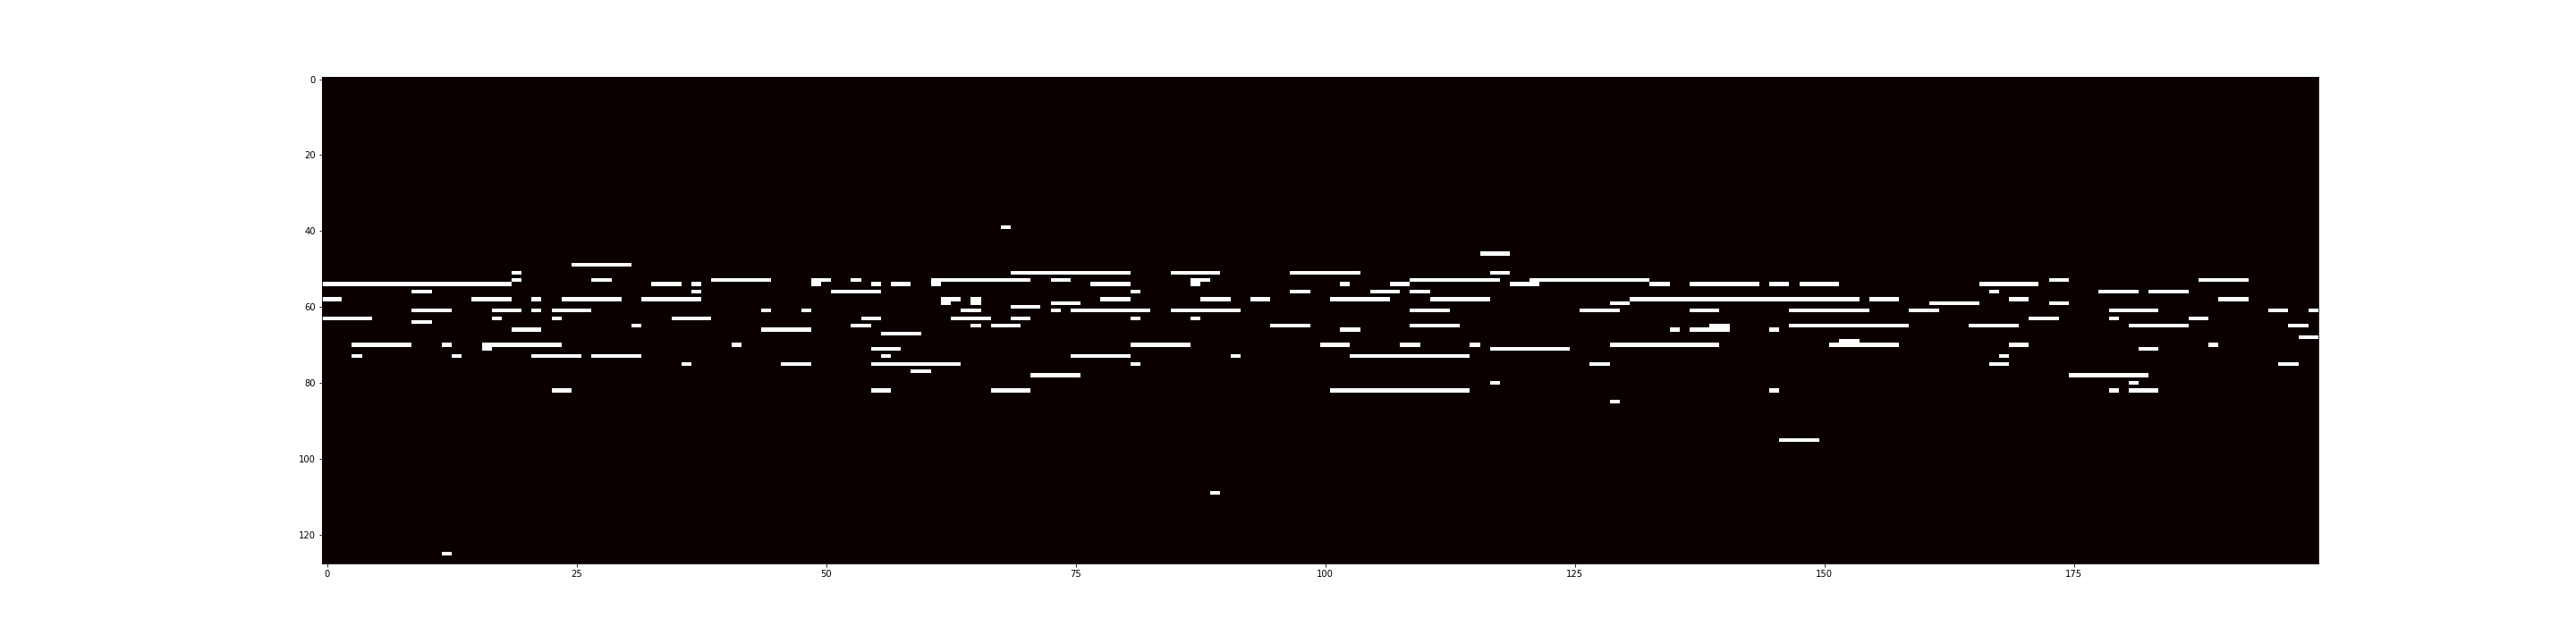

In [16]:
Image("plots/Exp5_note_hold__15beats__predicted_15_0dot01_3_1_1_128_15__12-21-2021_17-35-49.png")

### Predicting using 31 beats

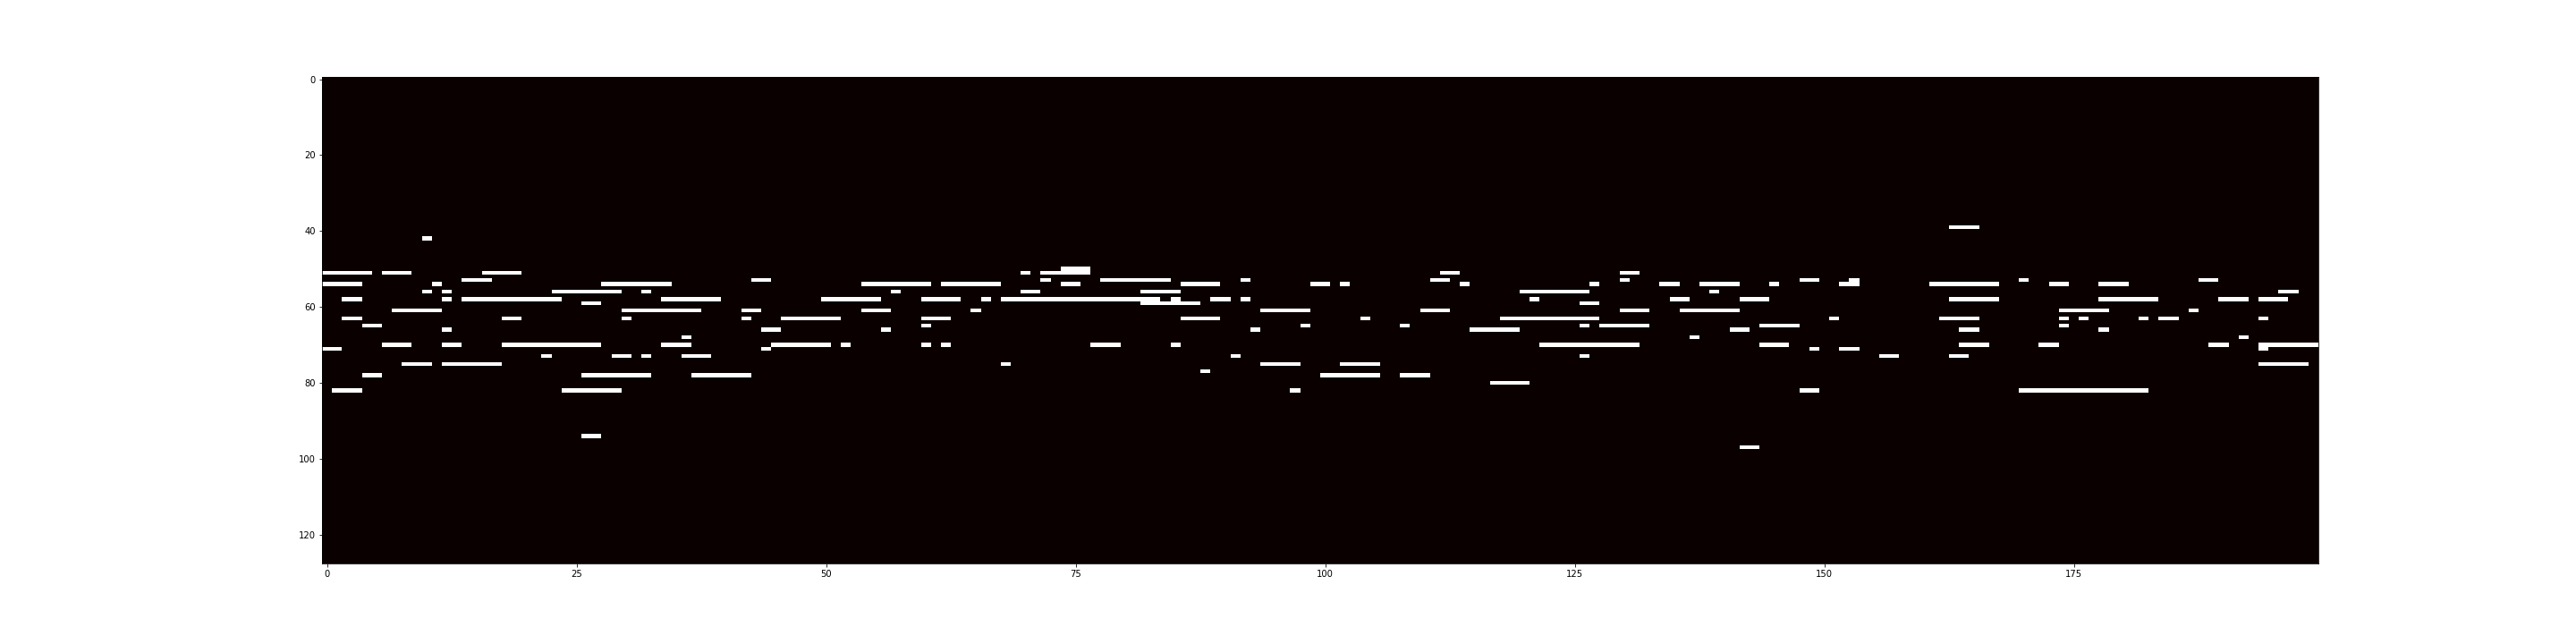

In [17]:
Image("plots/Exp5_note_hold__31beats__predicted_15_0dot01_3_1_1_128_31__12-21-2021_17-35-38.png")

## Experiment ? - Study on Batch Size

This is a note invariant model
- Trained using one song
- All 128 notes are input across the batch dimension
- The song time dimension is input into the LSTM tiime dimension

As shown in the results below, we found that training with a larger batch size results in the model not properly learning.

This makes sense because we are inputing different piano notes across the batch dimension. If we group many notes together the patterns dissapear and get entangled. For example, training using information from C and the adjacent C# note would suggest that C and C# would be played together. However, we know from music theory that playing to directly adjacent notes are not complementary. In fact this is refered to dissenant notes and results in bad sounding song.



In [19]:
print("Exp 5 predicting with single batch size")
exp.common_config["num_beats_for_prediction"] = 31
exp.common_config["batch_size"] = 1
exp.run()
exp.predict_and_save_data("_batch_1_")
exp.common_config["batch_size"] = 50
exp.run()
exp.predict_and_save_data("_batch_50_")

Exp 5 predicting with single batch size
in get_model self is <src.models.basic_rnn.RNNMusicExperimentFive object at 0x7f47d0470668>
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 128, 50)           20800     
_________________________________________________________________
lstm_19 (LSTM)               (None, 128, 50)           20200     
_________________________________________________________________
lstm_20 (LSTM)               (None, 128, 50)           20200     
_________________________________________________________________
dense_6 (Dense)              (None, 128, 2)            102       
Total params: 61,302
Trainable params: 61,302
Non-trainable params: 0
_________________________________________________________________


/home/ecbm4040/envTF24/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Training...
Epoch 1/3
1206/1206 [==============================] - 15s 10ms/step - loss: 0.0763 - mse: 0.0176
Epoch 2/3
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0430 - mse: 0.0107
Epoch 3/3
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0395 - mse: 0.0101
Predicting data...
Saving data...
Predicting data...
Saving data...
in get_model self is <src.models.basic_rnn.RNNMusicExperimentFive object at 0x7f47d0470668>
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 128, 50)           20800     
_________________________________________________________________
lstm_22 (LSTM)               (None, 128, 50)           20200     
_________________________________________________________________
lstm_23 (LSTM)               (None, 128, 50)           20200     
__________________________________________________

/home/ecbm4040/envTF24/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Training...
Epoch 1/3
25/25 [==============================] - 4s 21ms/step - loss: 0.2387 - mse: 0.0709
Epoch 2/3
25/25 [==============================] - 0s 14ms/step - loss: 0.0891 - mse: 0.0176
Epoch 3/3
25/25 [==============================] - 0s 14ms/step - loss: 0.0850 - mse: 0.0171
Predicting data...
Saving data...
Predicting data...
Saving data...


## Batch Size = 50

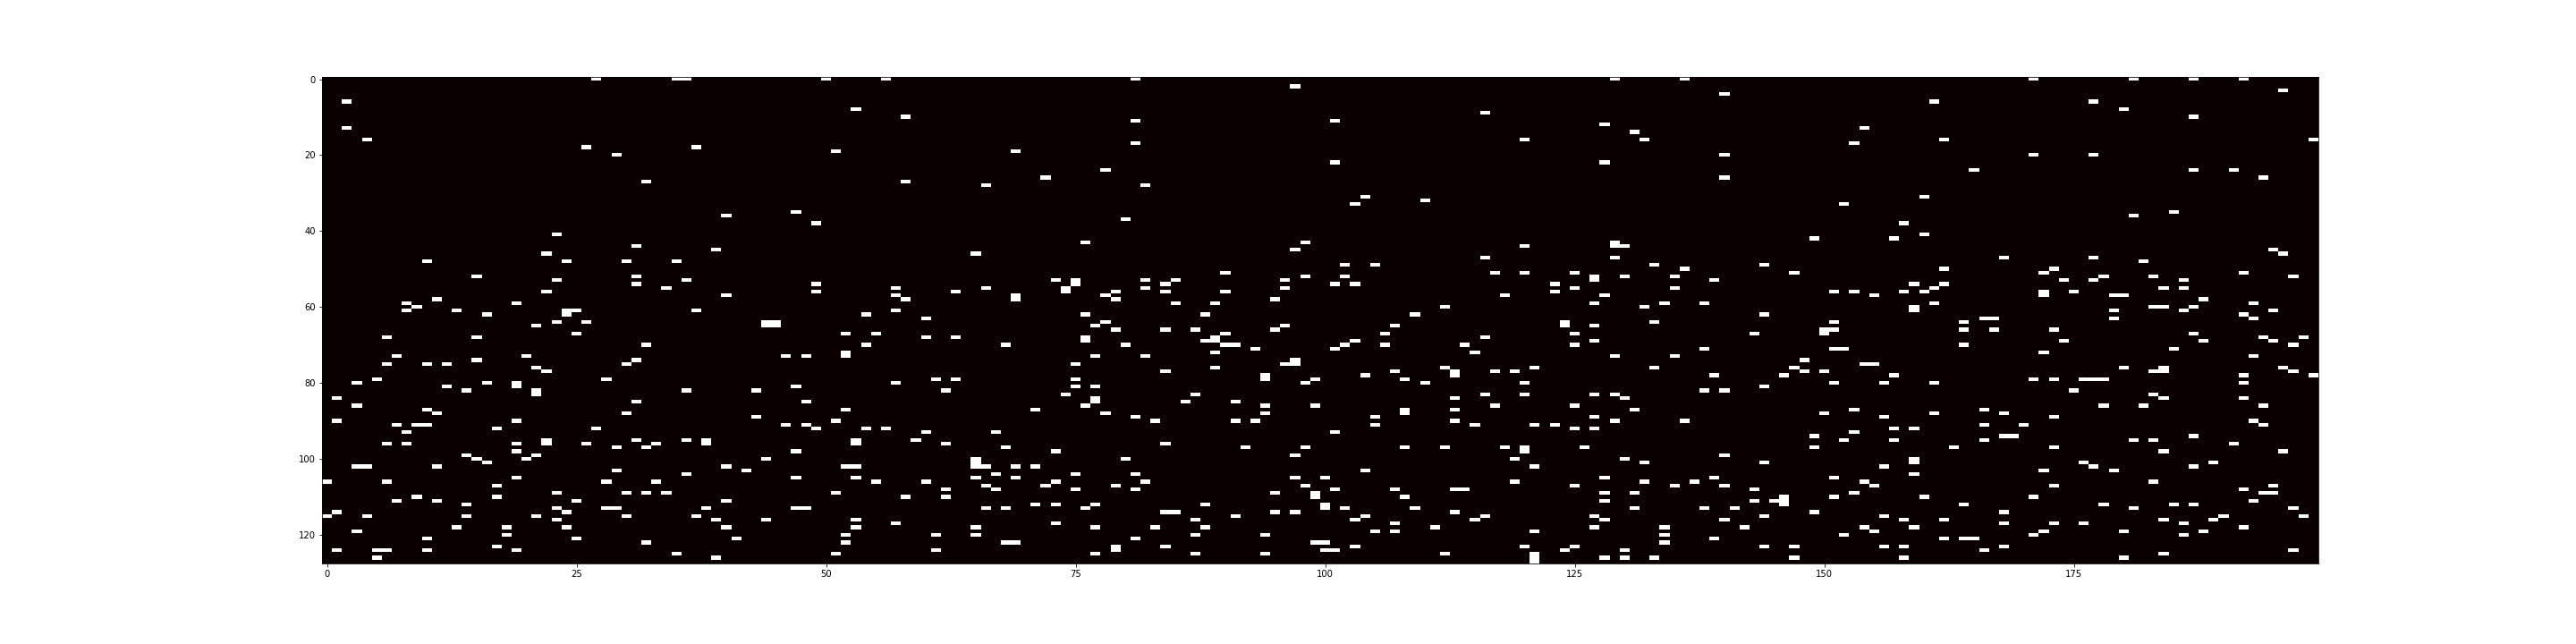

In [22]:
Image("plots/Exp5_note_hold__batch_50__predicted_15_0dot01_3_50_1_128_31__12-21-2021_18-14-28.png")

## Batch Size = 1

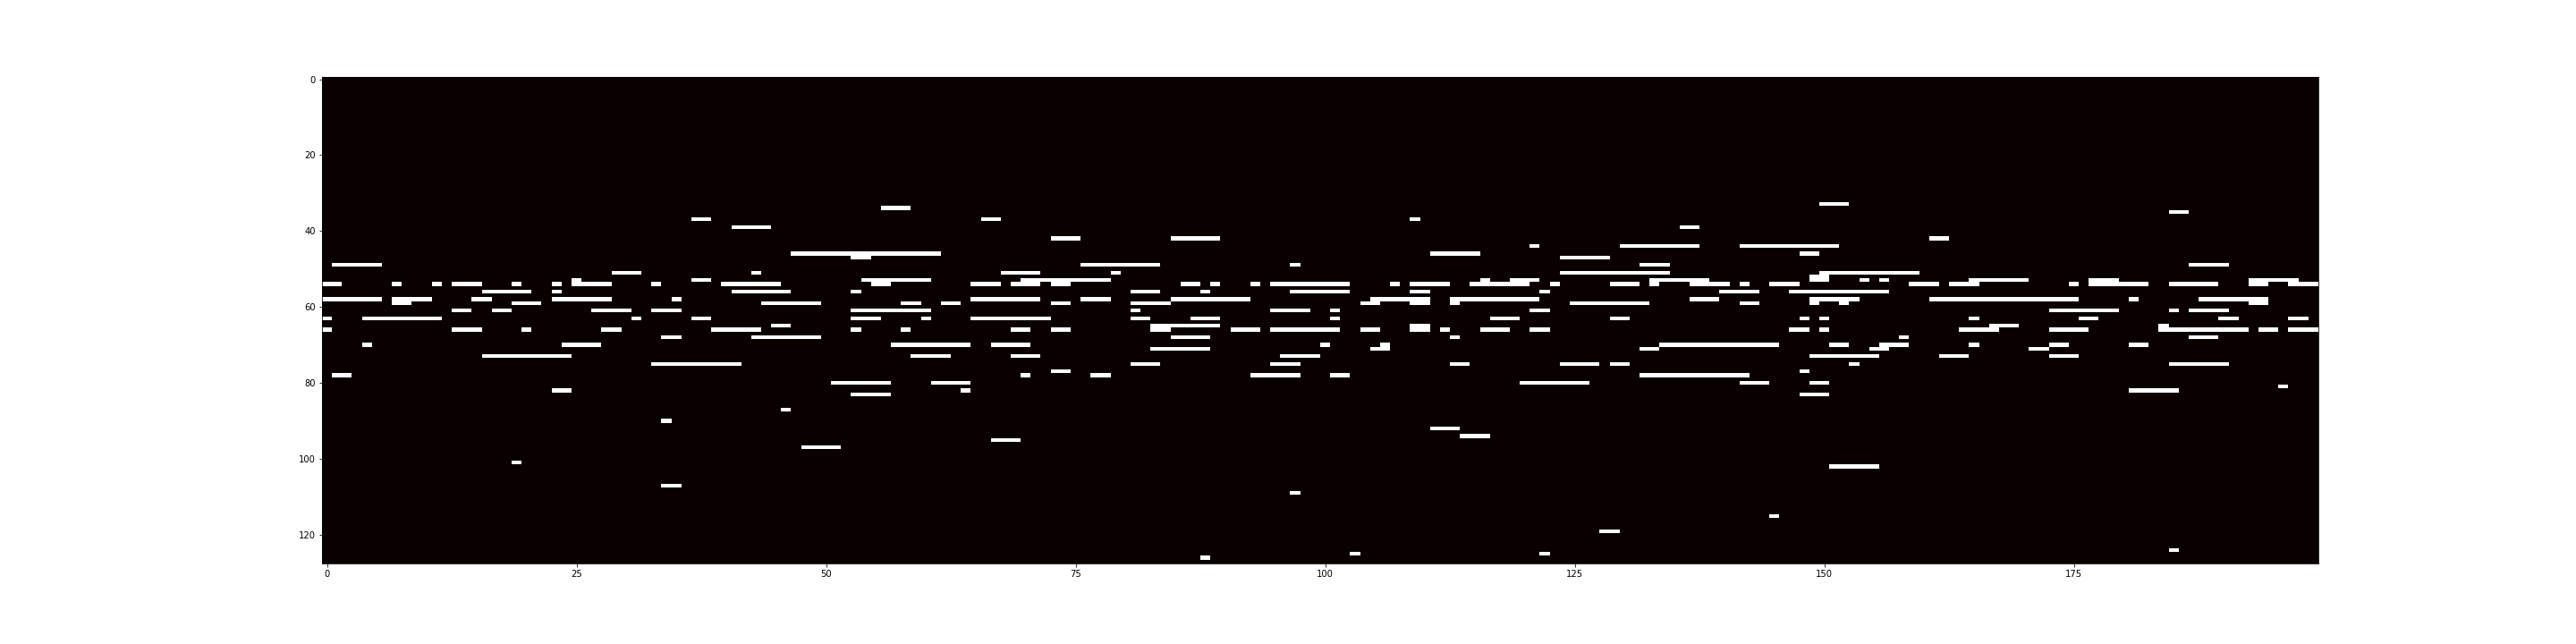

In [23]:
Image("plots/Exp5_note_hold__batch_1__predicted_15_0dot01_3_1_1_128_31__12-21-2021_18-13-55.png")

Experiment 5
in get_model self is <src.models.basic_rnn.RNNMusicExperimentFive object at 0x7f8845bc7fd0>
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 50)           20800     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128, 50)           20200     
_________________________________________________________________
dense_1 (Dense)              (None, 128, 2)            102       
Total params: 61,302
Trainable params: 61,302
Non-trainable params: 0
_________________________________________________________________


/home/ecbm4040/envTF24/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Training...
1206/1206 [==============================] - 15s 10ms/step - loss: 0.0711 - mse: 0.0160
Predicting data...
Saving data...
Exp 5 predicting with 31 beats
Predicting data...
Saving data...


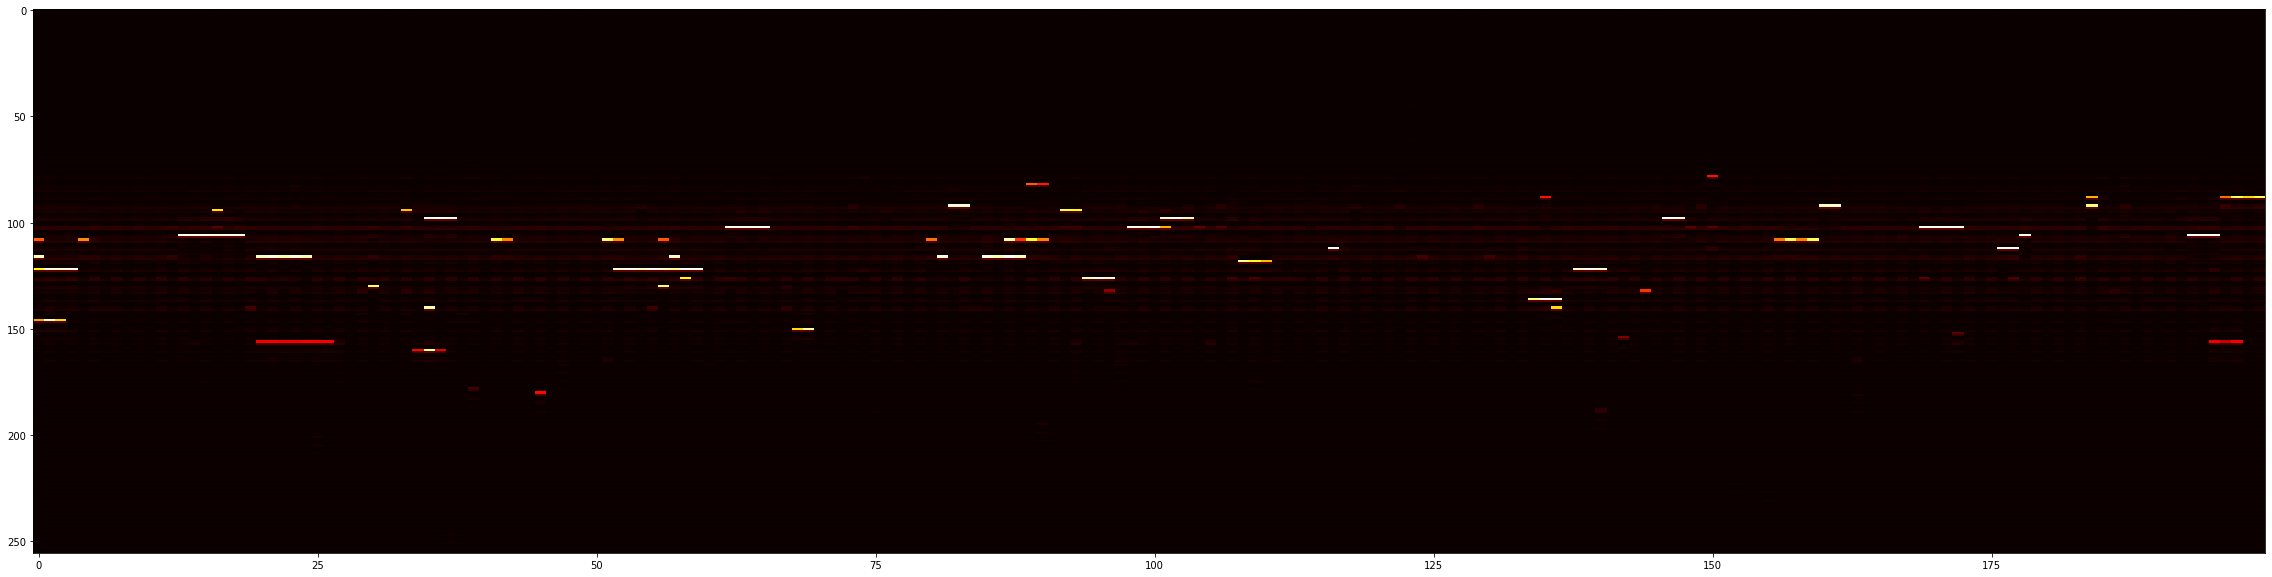

In [11]:
print("Experiment 5")
exp5 = brnn.RNNMusicExperimentFive(
    learning_rate=0.01,
    epochs=1,
    batch_size=1,
    num_music_files=1
)
exp5.run()
print("Exp 5 predicting with 31 beats")
exp5.common_config["num_beats_for_prediction"] = 31
exp5.predict_and_save_data()

## Study on note vicinity


Note vicinity refers to how many adjacent notes are used to predict the follow note. For example, with a single octave vicinity, middle C note uses one octave above and one octave below to predict whether the next middle C should be played or not. The original author describes using 2 octaves above and 2 octaves below. We wanted to experiment with this values to understand how it affects the model.


## Results on note vicinity

From the plots show below, we can see noticibly differences between the models. The model only using 1 octave above and below tends to play notes closer together on the piano keys. This makes sense because when the highest keys on piano are determining whether they should be played or not, only the models with a larger vicinity will have a view into the notes on the center of the piano roll to play. The models with a small vicinity don't see any notes being played and so they never predict more notes being played

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_111 (LSTM)              (None, 128, 50)           20800     
_________________________________________________________________
lstm_112 (LSTM)              (None, 128, 50)           20200     
_________________________________________________________________
lstm_113 (LSTM)              (None, 128, 50)           20200     
_________________________________________________________________
dense_37 (Dense)             (None, 128, 2)            102       
Total params: 61,302
Trainable params: 61,302
Non-trainable params: 0
_________________________________________________________________


/home/ecbm4040/envTF24/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Training...
Epoch 1/3
1206/1206 [==============================] - 15s 10ms/step - loss: 0.0750 - mse: 0.0166
Epoch 2/3
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0420 - mse: 0.0105
Epoch 3/3
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0397 - mse: 0.0102
Predicting data...
Saving data...
Predicting data...
Saving data...
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_114 (LSTM)              (None, 128, 50)           25600     
_________________________________________________________________
lstm_115 (LSTM)              (None, 128, 50)           20200     
_________________________________________________________________
lstm_116 (LSTM)              (None, 128, 50)           20200     
_________________________________________________________________
dense_38 (Dense)             (None, 128, 2)            102       
Total par

/home/ecbm4040/envTF24/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Training...
Epoch 1/3
1206/1206 [==============================] - 15s 10ms/step - loss: 0.0739 - mse: 0.0164
Epoch 2/3
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0405 - mse: 0.0102
Epoch 3/3
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0391 - mse: 0.0100
Predicting data...
Saving data...
Predicting data...
Saving data...


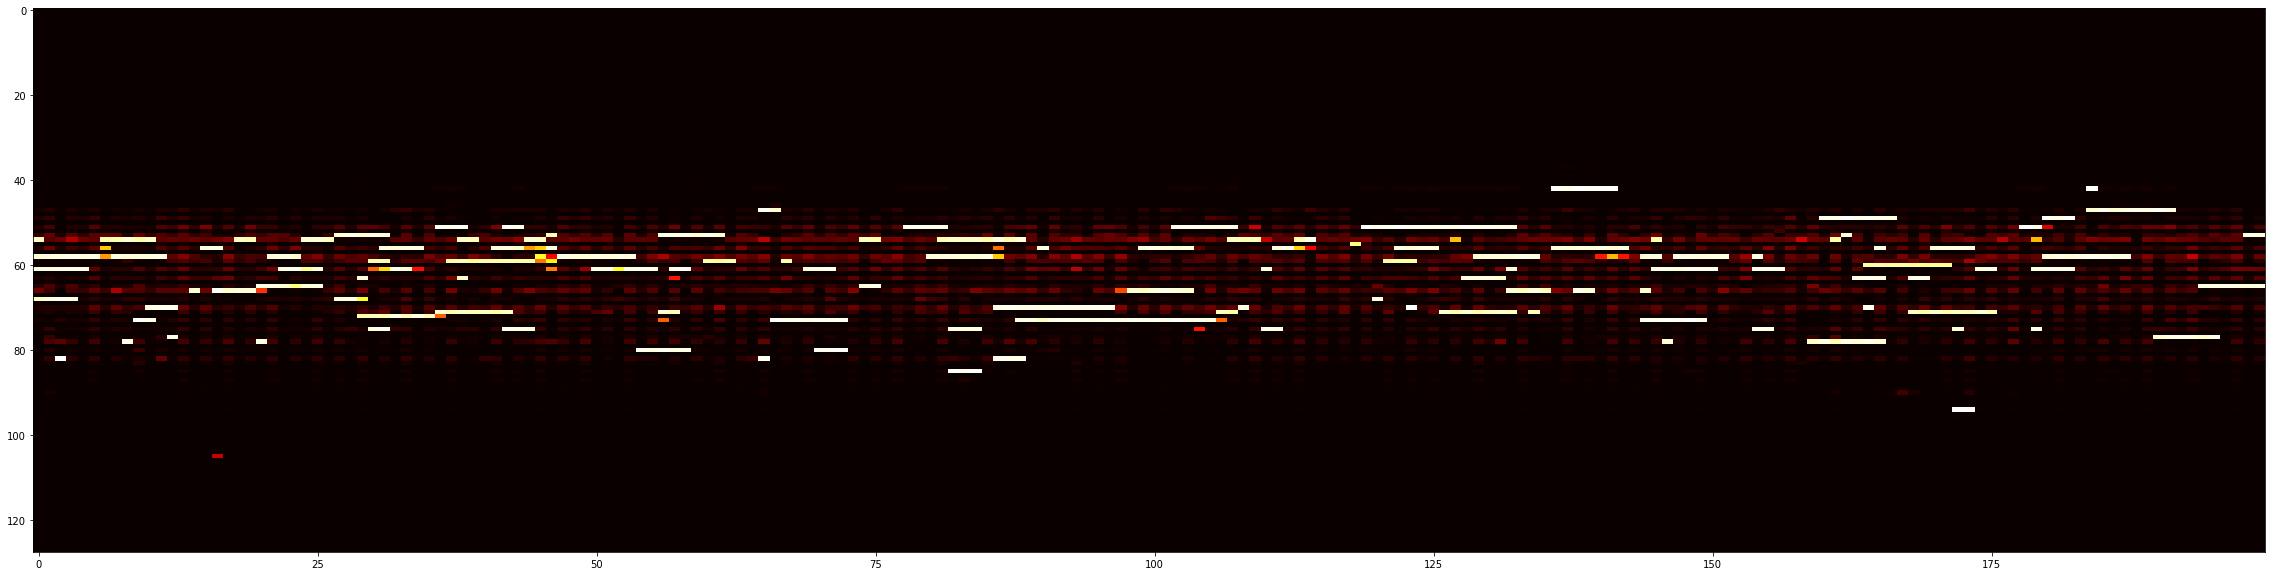

In [65]:
exp7 = brnn.RNNMusicExperimentSeven(
    learning_rate=0.01,
    epochs=3,
    batch_size=1,
    num_music_files=1,
    note_vicinity=24,
)
exp7.run()
exp7.predict_and_save_data("_1octave_")

exp7 = brnn.RNNMusicExperimentSeven(
    learning_rate=0.01,
    epochs=3,
    batch_size=1,
    num_music_files=1,
    note_vicinity=48,
)
exp7.run()
exp7.predict_and_save_data("_2octave_")

## Using 2 Octave Vicinity

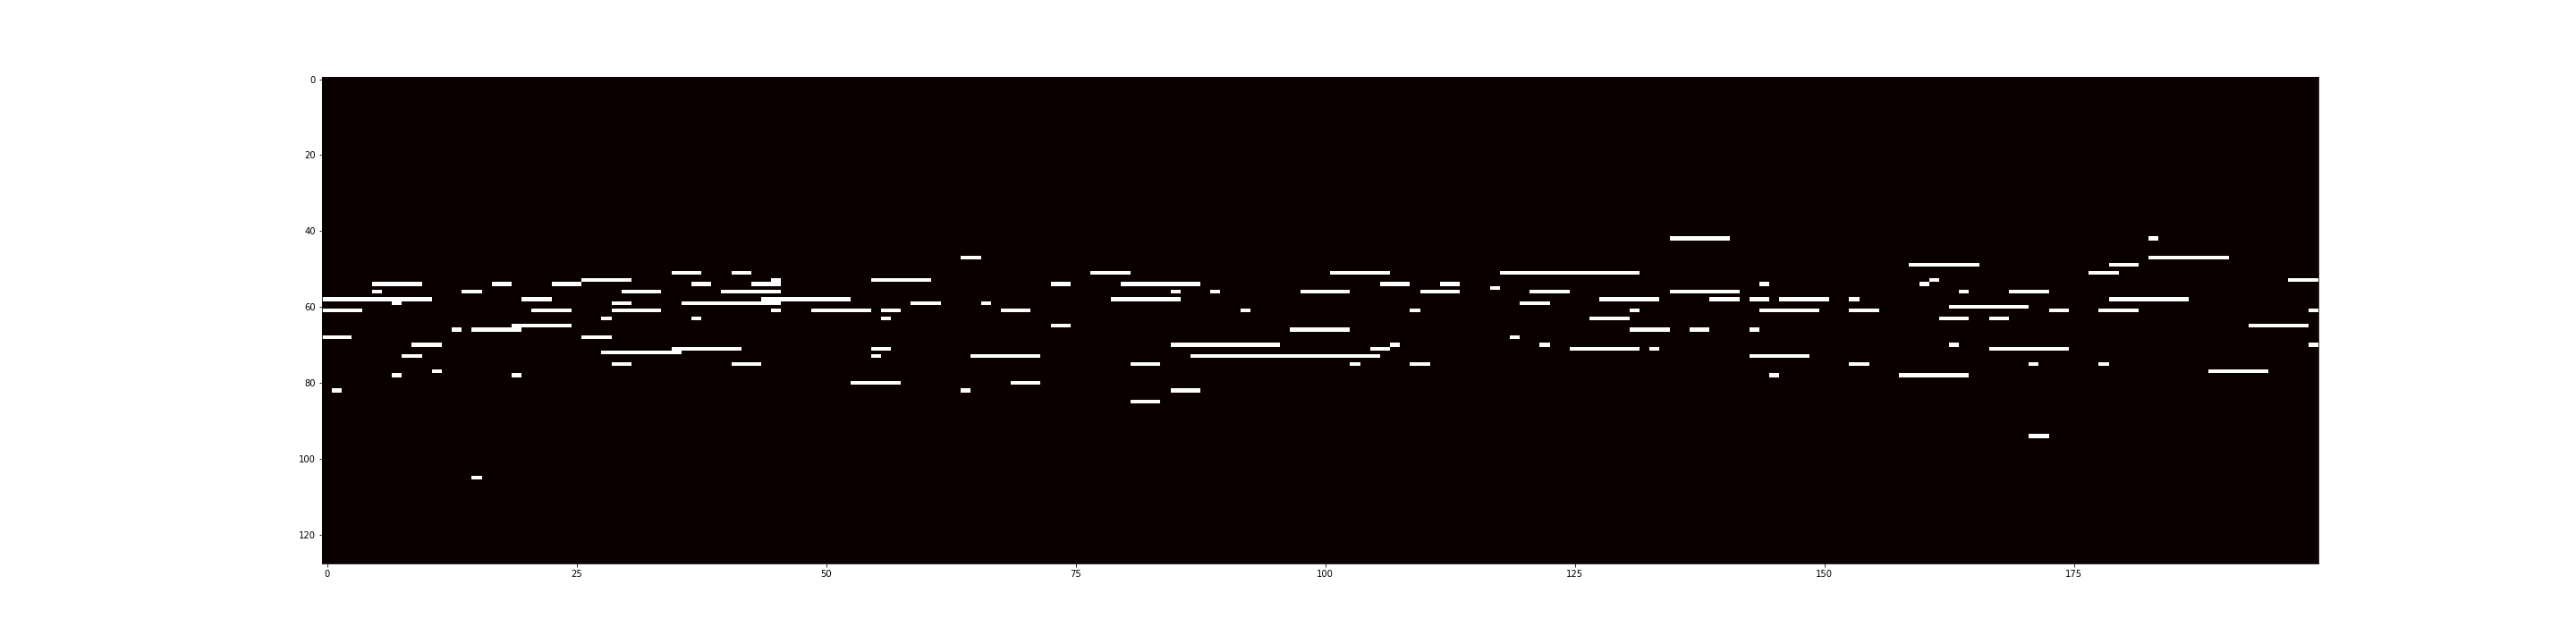

In [66]:
Image("plots/Exp7_note_hold__2octave__predicted_15_0dot01_3_1_1_128_1_48__12-21-2021_21-19-22.png")

## Using 1 Octave Vicinity

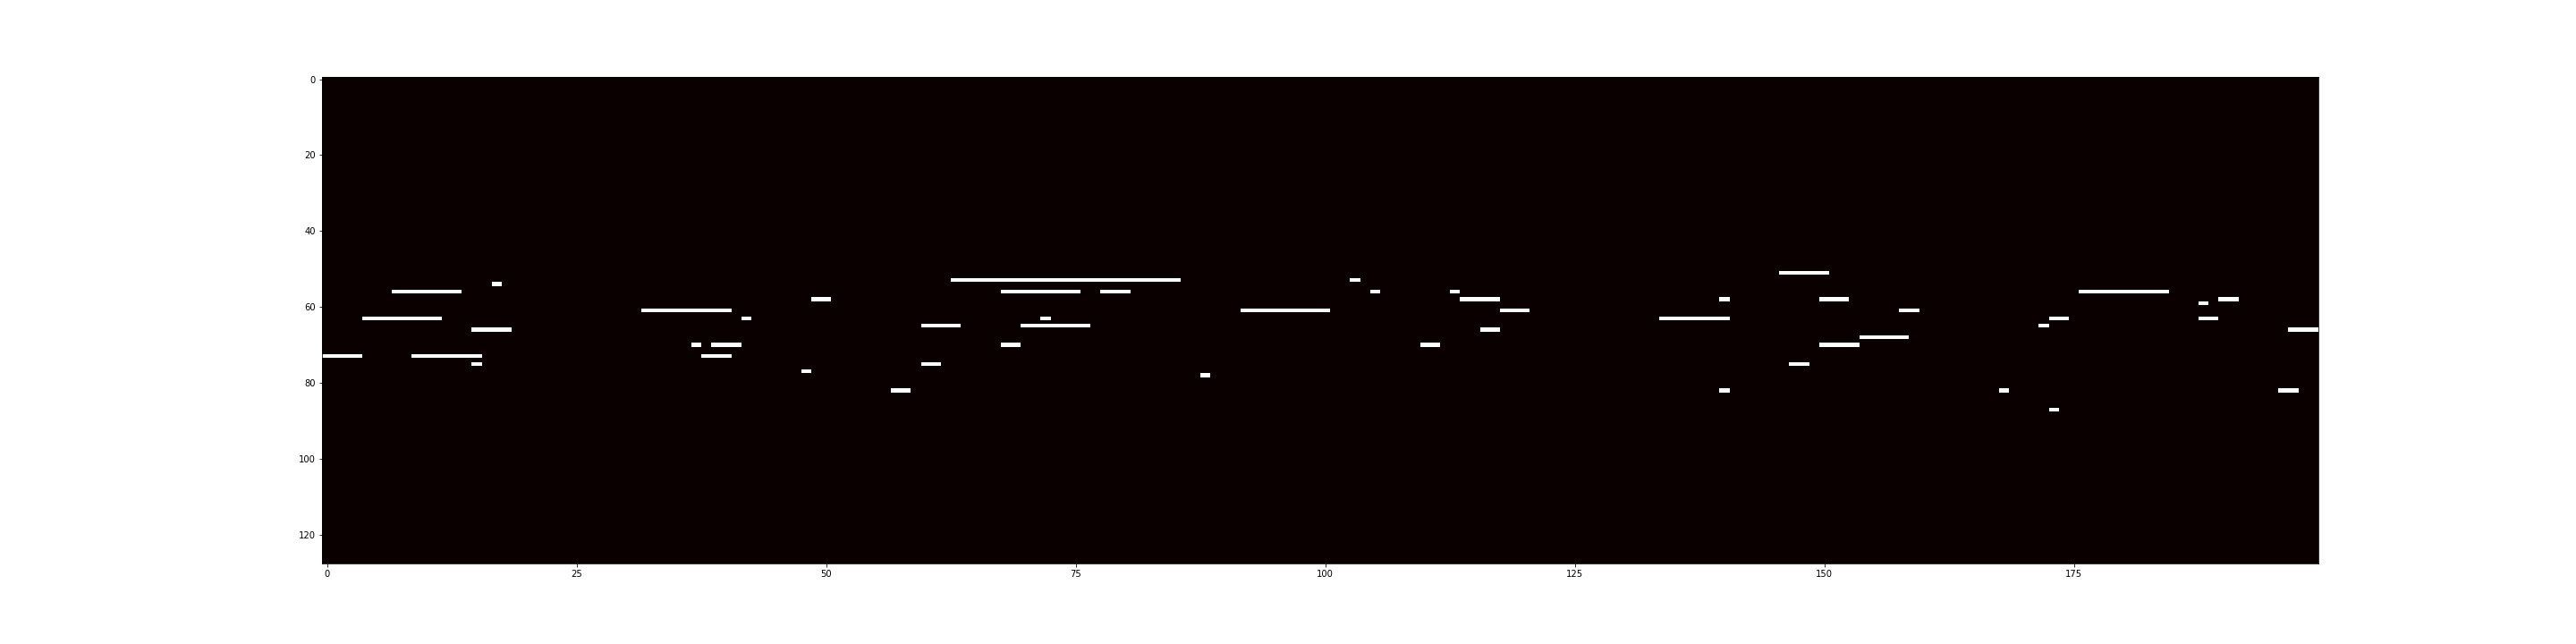

In [67]:
Image("plots/Exp7_note_hold__1octave__predicted_15_0dot01_3_1_1_128_1_24__12-21-2021_21-18-02.png")

## Experiment: Study on increasing the capacity of the model


Given we are trying to learn complex sequences it is natural to experiment with the number of hidden layers in our LSTM model. 

We firstly notice that increasing the number of hidden layers in the LSTM makes the model harder to train. We compensate for this by decreasing the learning rate and increasing the number of training epochs.

There isn't a clear result as to whether more or less capacity is needed. In this experiment we are only training on a single song. This might be the reason the result isn't as pronounced here. As we train on more songs, it is possible that the number of hidden nodes becomes more important as we need the neural network to recognize complex relationships that appear across many songs.

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_90 (LSTM)               (None, 128, 50)           25600     
_________________________________________________________________
lstm_91 (LSTM)               (None, 128, 50)           20200     
_________________________________________________________________
lstm_92 (LSTM)               (None, 128, 50)           20200     
_________________________________________________________________
dense_30 (Dense)             (None, 128, 2)            102       
Total params: 66,102
Trainable params: 66,102
Non-trainable params: 0
_________________________________________________________________


/home/ecbm4040/envTF24/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Training...
Epoch 1/5
1206/1206 [==============================] - 15s 10ms/step - loss: 0.0819 - mse: 0.0179
Epoch 2/5
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0432 - mse: 0.0109
Epoch 3/5
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0422 - mse: 0.0110
Epoch 4/5
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0375 - mse: 0.0096
Epoch 5/5
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0404 - mse: 0.0104
Predicting data...
Saving data...
Predicting data...
Saving data...
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 128, 100)          71200     
_________________________________________________________________
lstm_94 (LSTM)               (None, 128, 100)          80400     
_________________________________________________________________
lstm_95 (LS

/home/ecbm4040/envTF24/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Training...
Epoch 1/8
1206/1206 [==============================] - 15s 10ms/step - loss: 0.0743 - mse: 0.0167
Epoch 2/8
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0420 - mse: 0.0105
Epoch 3/8
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0415 - mse: 0.0104
Epoch 4/8
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0416 - mse: 0.0103
Epoch 5/8
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0408 - mse: 0.0104
Epoch 6/8
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0411 - mse: 0.0104
Epoch 7/8
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0405 - mse: 0.0103
Epoch 8/8
1206/1206 [==============================] - 12s 10ms/step - loss: 0.0411 - mse: 0.0105
Predicting data...
Saving data...
Predicting data...
Saving data...
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape      

/home/ecbm4040/envTF24/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


Training...
Epoch 1/10
1206/1206 [==============================] - 24s 18ms/step - loss: 0.0938 - mse: 0.0189
Epoch 2/10
1206/1206 [==============================] - 21s 18ms/step - loss: 0.0900 - mse: 0.0176
Epoch 3/10
1206/1206 [==============================] - 21s 18ms/step - loss: 0.0859 - mse: 0.0174
Epoch 4/10
1206/1206 [==============================] - 21s 18ms/step - loss: 0.0840 - mse: 0.0172
Epoch 5/10
1206/1206 [==============================] - 21s 18ms/step - loss: 0.0838 - mse: 0.0173
Epoch 6/10
1206/1206 [==============================] - 21s 18ms/step - loss: 0.0827 - mse: 0.0171
Epoch 7/10
1206/1206 [==============================] - 21s 18ms/step - loss: 0.0835 - mse: 0.0174
Epoch 8/10
1206/1206 [==============================] - 21s 18ms/step - loss: 0.0846 - mse: 0.0175
Epoch 9/10
1206/1206 [==============================] - 21s 18ms/step - loss: 0.0793 - mse: 0.0171
Epoch 10/10
1206/1206 [==============================] - 21s 18ms/step - loss: 0.0733 - mse: 0.01

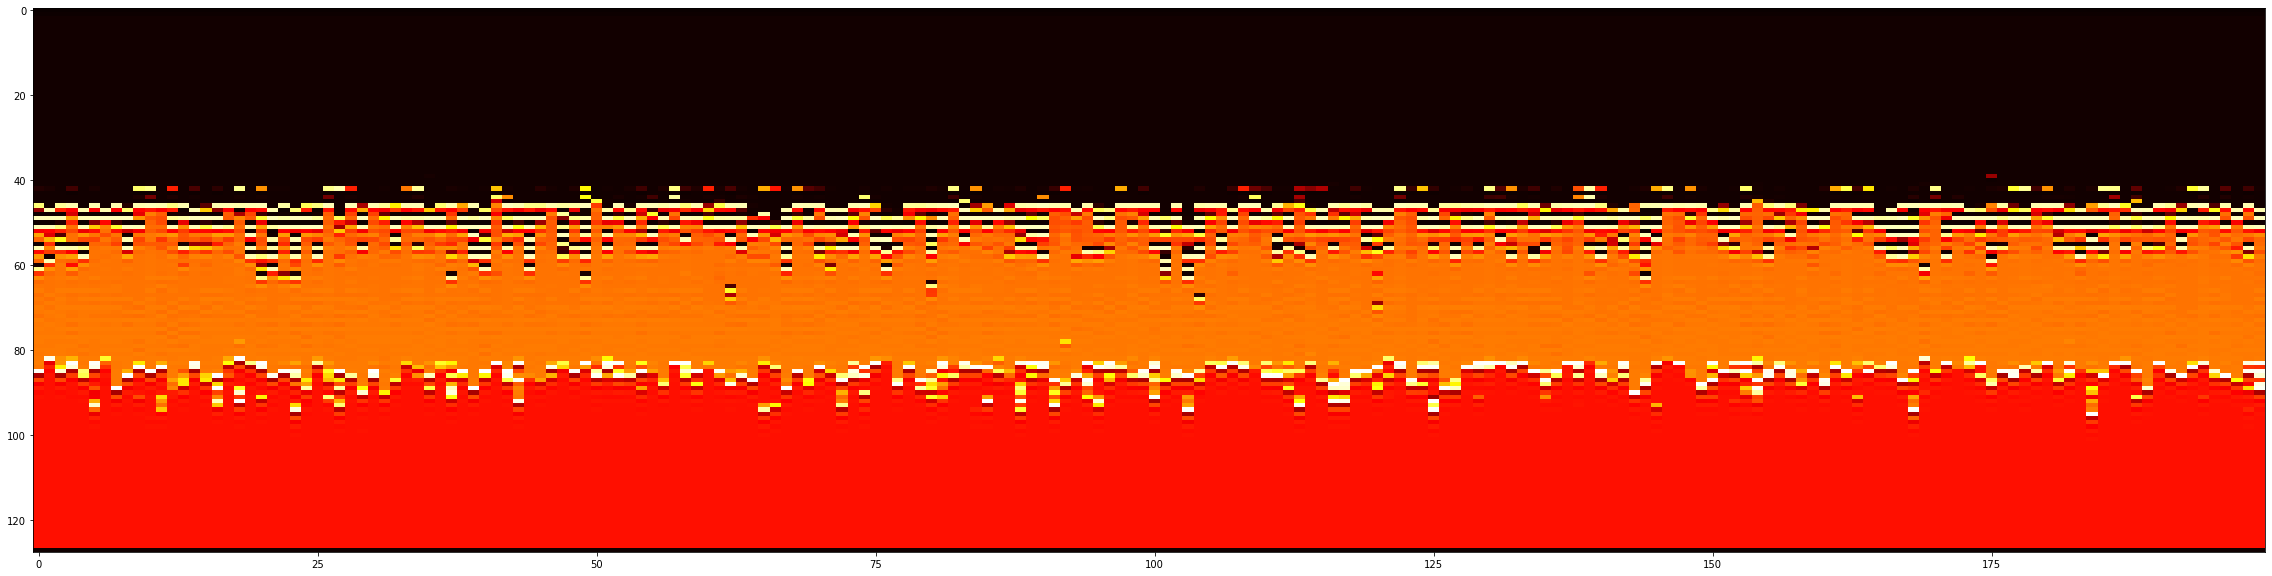

In [54]:
exp8 = brnn.RNNMusicExperimentEight(
    learning_rate=0.01,
    epochs=5,
    batch_size=1,
    num_music_files=1,
    num_hidden_nodes=50,
    note_vicinity=48,
)
exp8.run()
exp8.predict_and_save_data("_50nodes_")

exp8 = brnn.RNNMusicExperimentEight(
    learning_rate=0.01,
    epochs=8,
    batch_size=1,
    num_music_files=1,
    note_vicinity=48,
    num_hidden_nodes=100,
)
exp8.run()
exp8.predict_and_save_data("_100nodes_")


exp8 = brnn.RNNMusicExperimentEight(
    learning_rate=0.005,
    epochs=20,
    batch_size=1,
    num_music_files=1,
    note_vicinity=48,
    num_hidden_nodes=300,
)
exp8.run()
exp8.predict_and_save_data("_300nodes_")


## Number of nodes 50

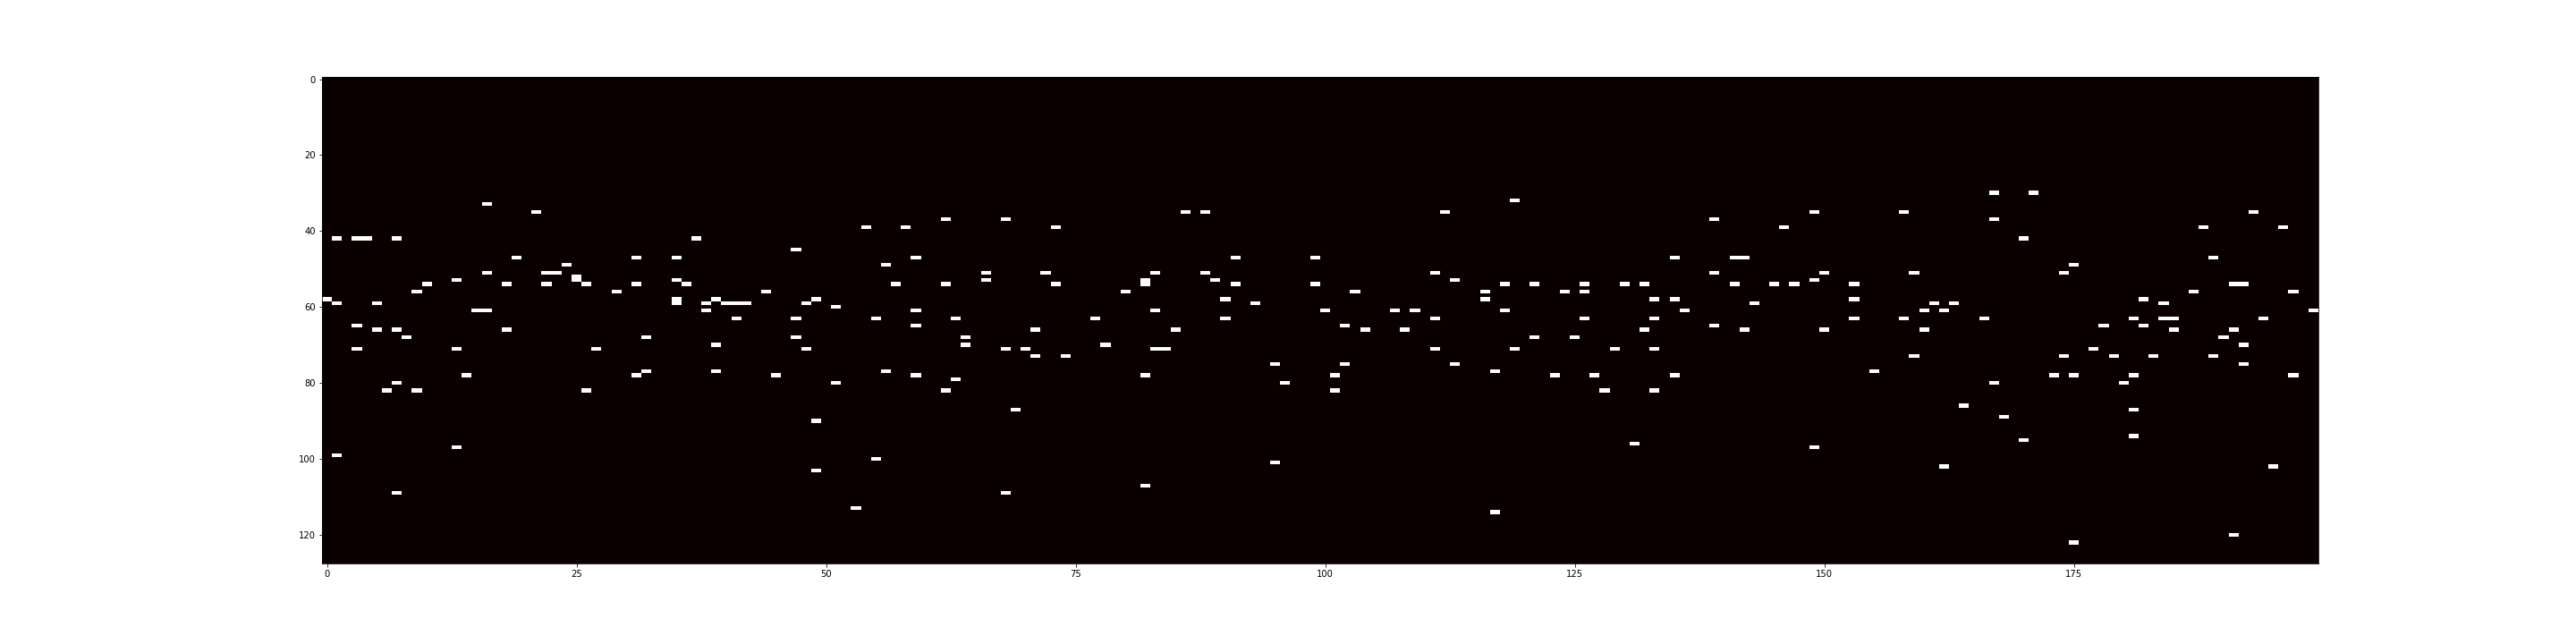

In [64]:
Image("plots/Exp8_artic__50nodes__predicted_15_0dot01_5_1_1_128_1_48_50__12-21-2021_20-32-08.png")

## Number of nodes 100


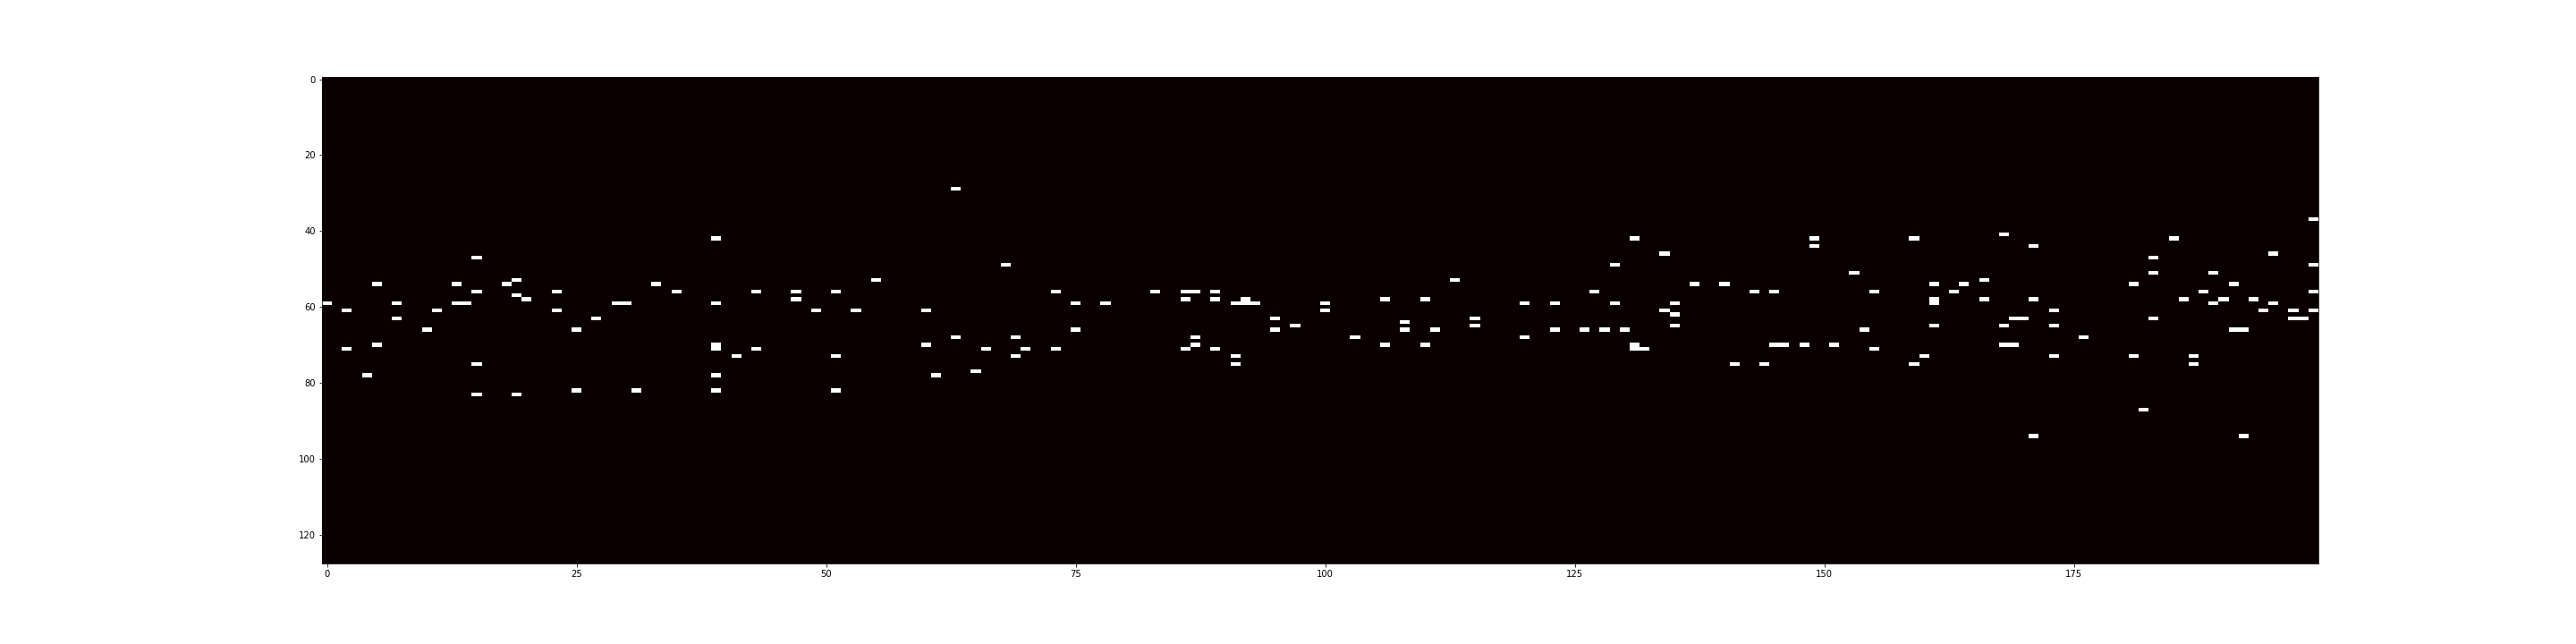

In [71]:
Image("plots/Exp8_artic__100&&nodes__predicted_15_0dot005_10_1_1_128_1_48_100__12-21-2021_21-32-02.png")

## Number of nodes 300

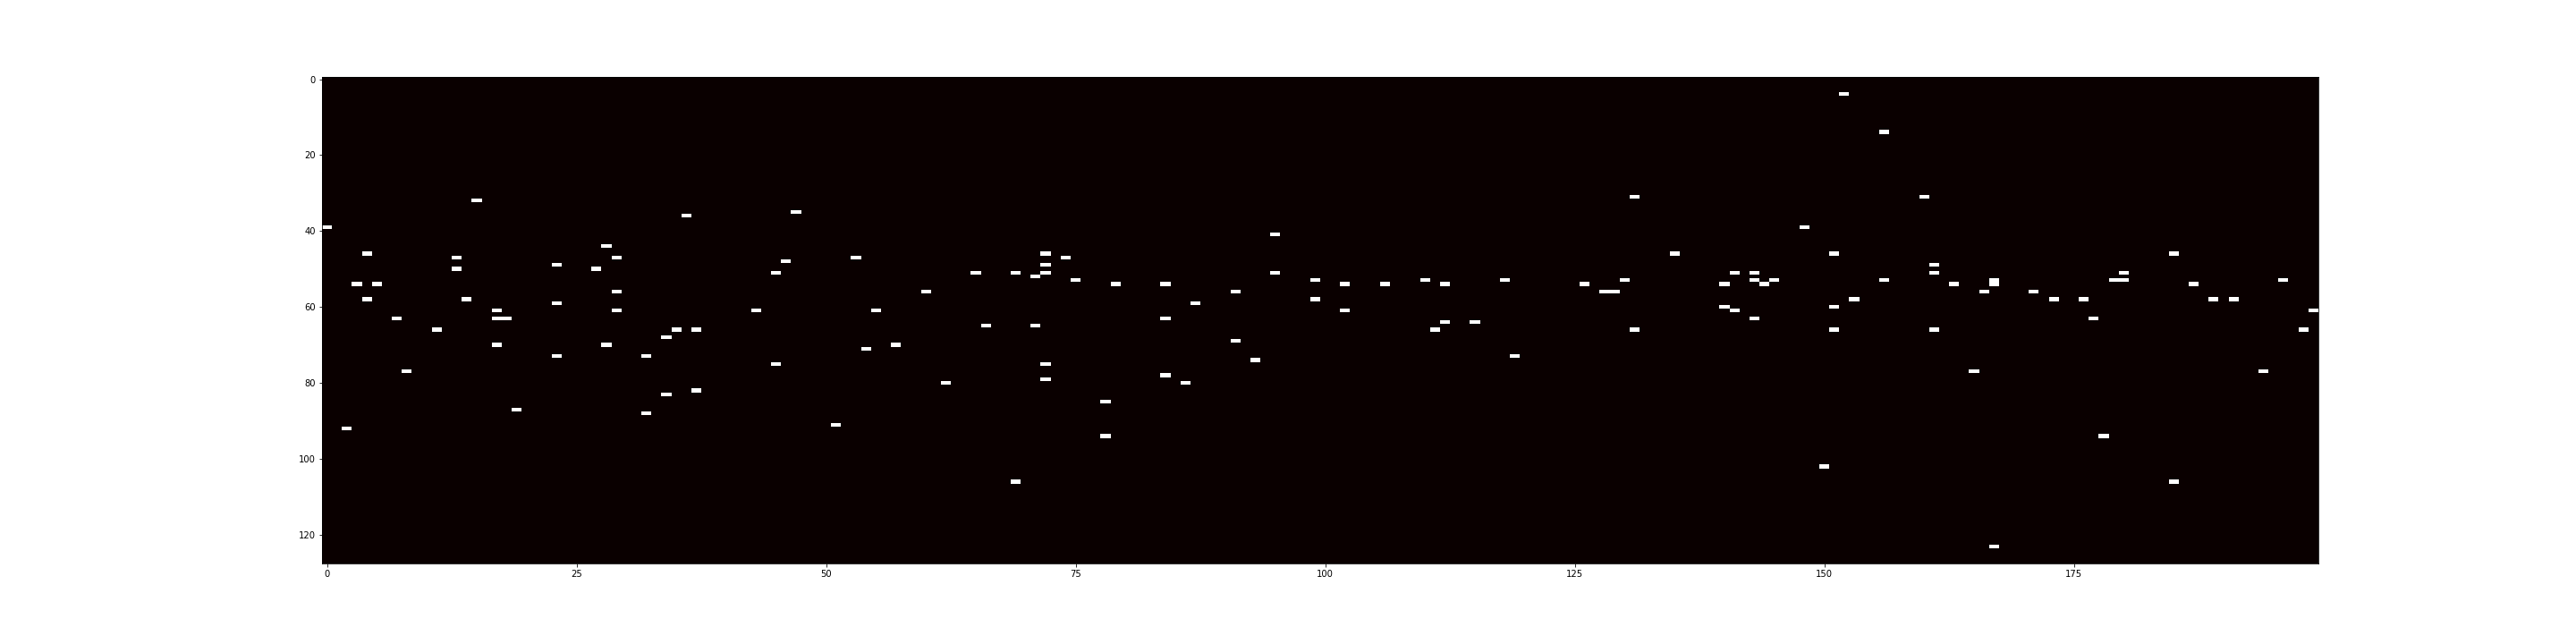

In [62]:
Image("plots/Exp8_artic__300nodes__predicted_15_0dot005_20_1_1_128_1_48_300__12-21-2021_20-53-55.png")

Predicting data...
Saving data...


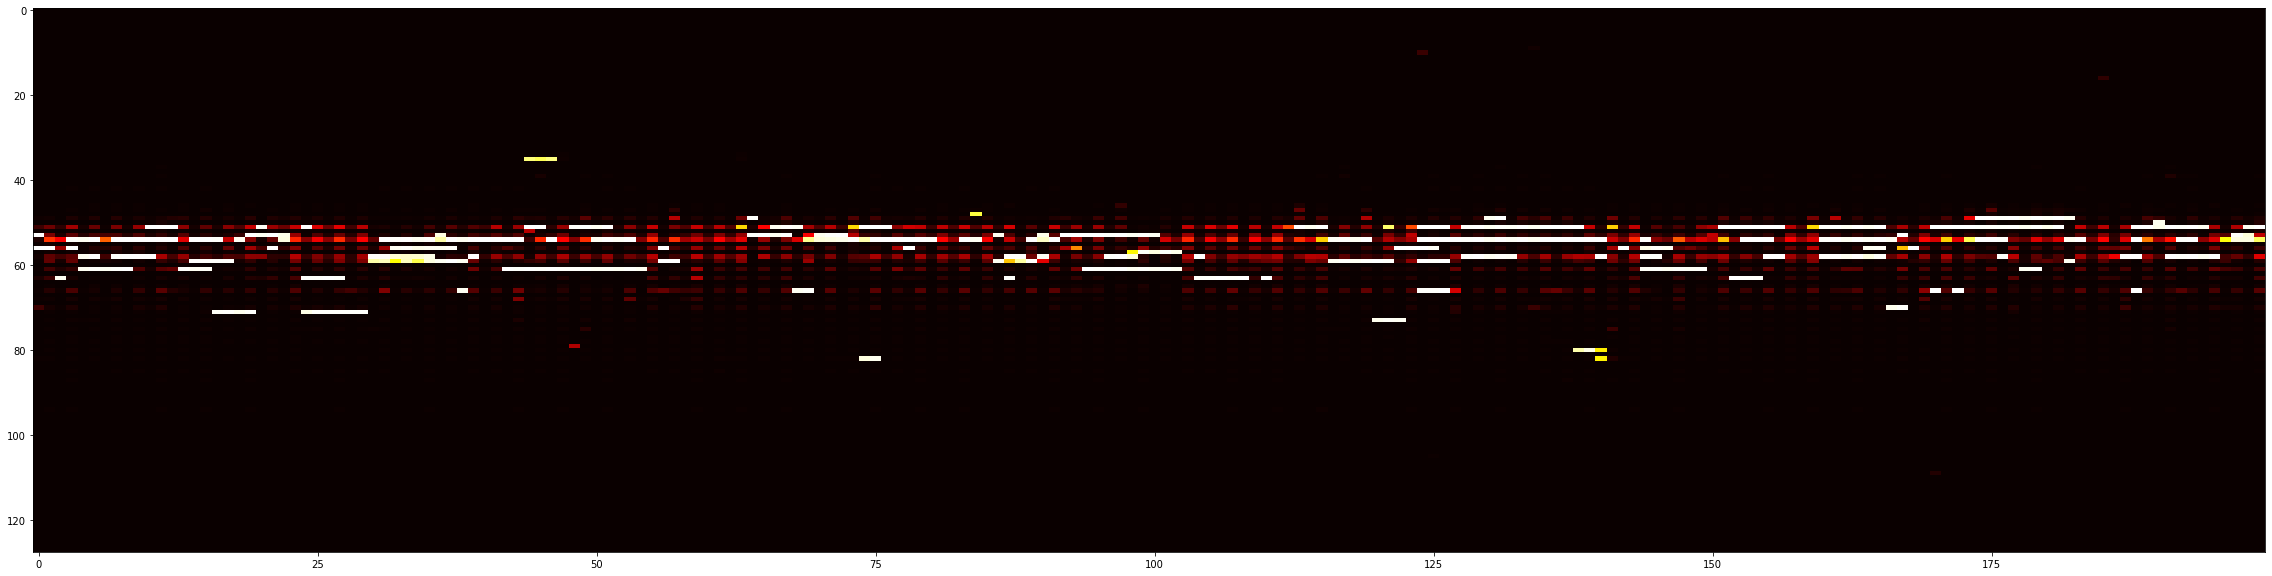

In [60]:
exp8.common_config["num_beats_for_prediction"] = 63
exp8.predict_and_save_data("_300&&nodes_")

# Exp 9 - Putting it all together with many files

This model was trained using 20 songs. It has 4 layers of 300 hidden LSTM nodes. Prediction was done using a sequence of 63 notes. 

## Analyzing results below

The color intensity shows which notes have the highest probability of being predicted next. An interesting result is shown in the center lower part of the graph where there is a sequence of 3 increasing notes. The trained model know that the next following notes should be close and likely increasing. Furthermore, we can see that the model is likely predicting the following notes in the same key as it increases by whole steps rather than half steps.

In [ ]:
exp9 = brnn.RNNMusicExperimentNine(
    learning_rate=0.0001,
    epochs=1,
    batch_size=1,
    num_music_files=30,
    num_hidden_nodes=300,
    note_vicinity=48,
)
exp9.run()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 300)          453600    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128, 300)          721200    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128, 300)          721200    
_________________________________________________________________
dense_1 (Dense)              (None, 128, 2)            602       
Total params: 1,896,602
Trainable params: 1,896,602
Non-trainable params: 0
_________________________________________________________________
Training...


In [ ]:
exp9.common_config["learning_rate"] = 0.01
exp9.common_config["note_vicinity"] = 24
exp9.common_config["epochs"] = 1
exp9.train_model(exp9.prepared_data)

Predicting data...
Saving data...


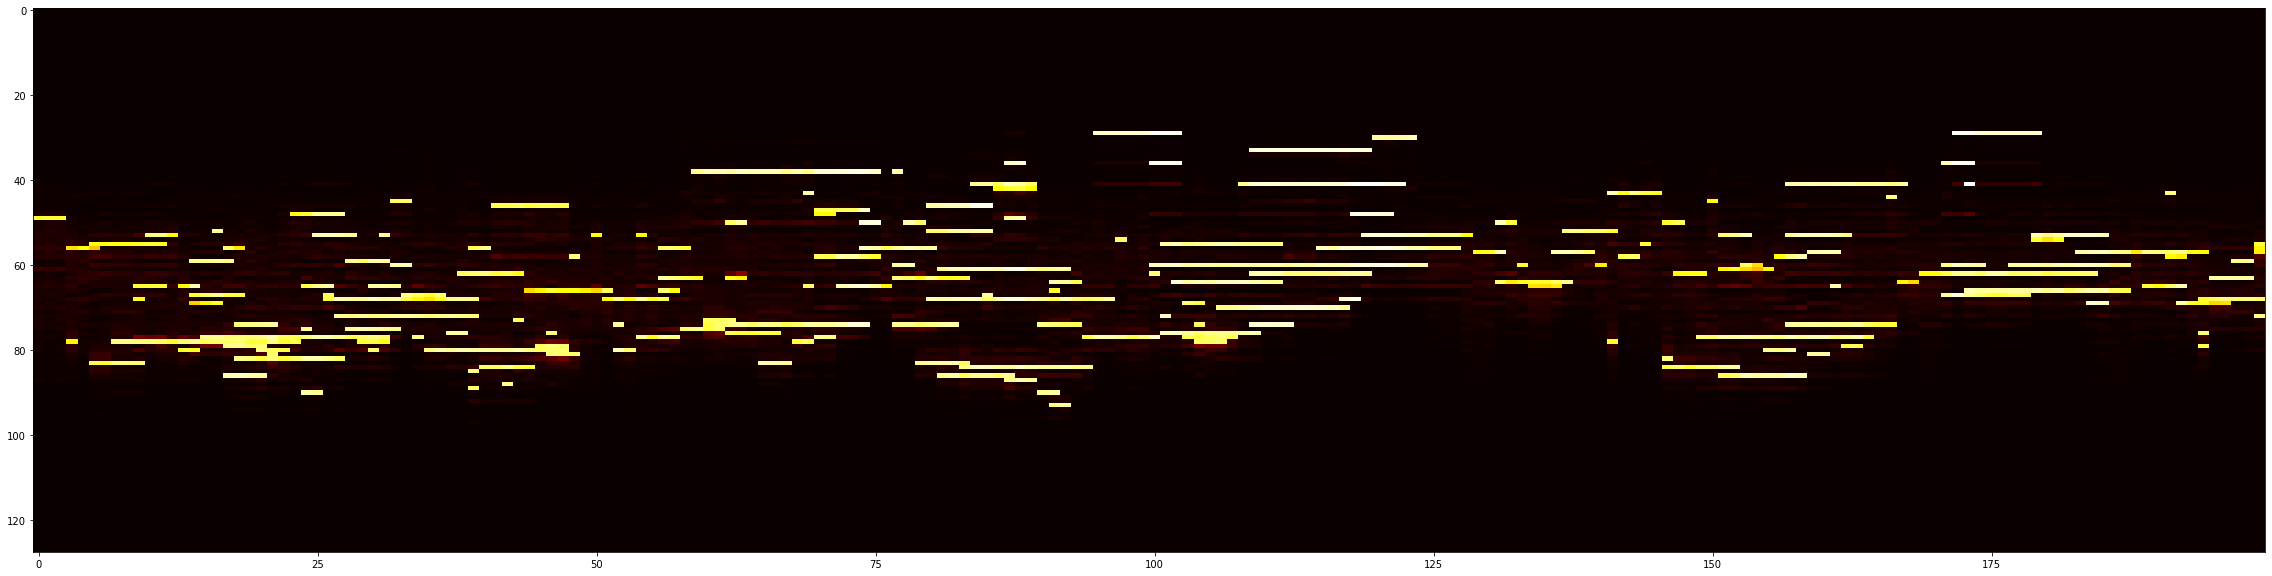

In [78]:
exp9.common_config["num_beats_for_prediction"] = 31
exp9.predict_and_save_data("_exp9_everything_31_")

## Experiment 9 Song output

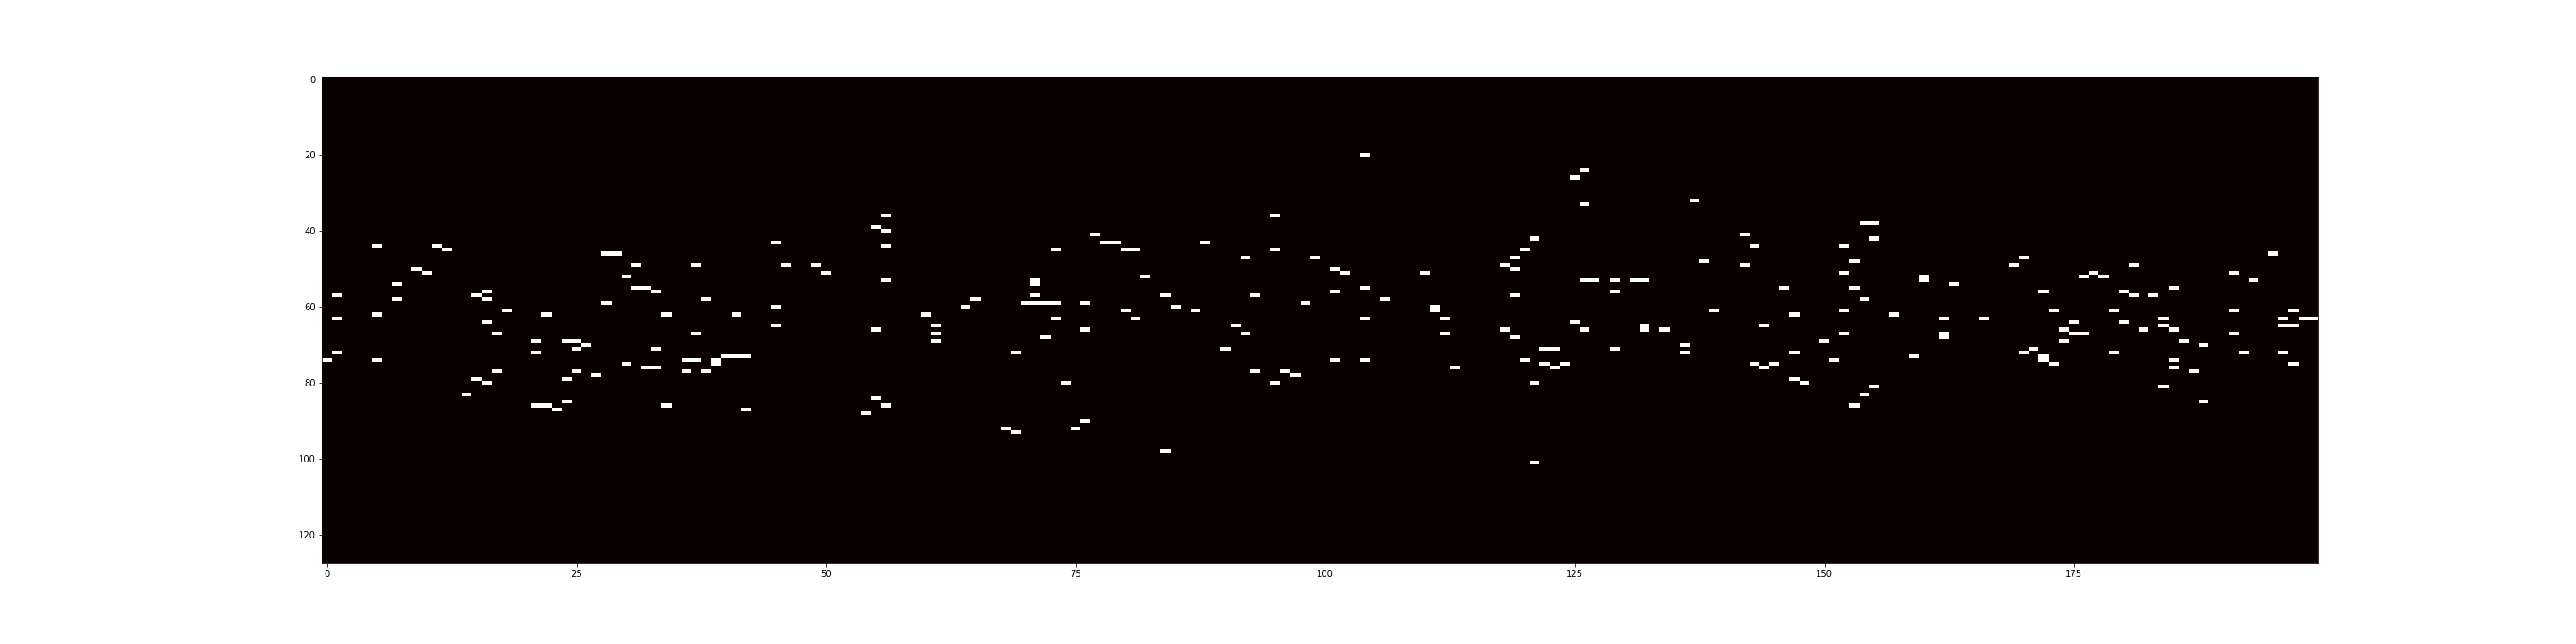

In [79]:
Image("plots/Exp8_artic__exp9_everything__predicted_15_0dot0005_20_1_20_128_63_48_300__12-21-2021_22-30-32.png")

## Experiment 9 Prediction Probability

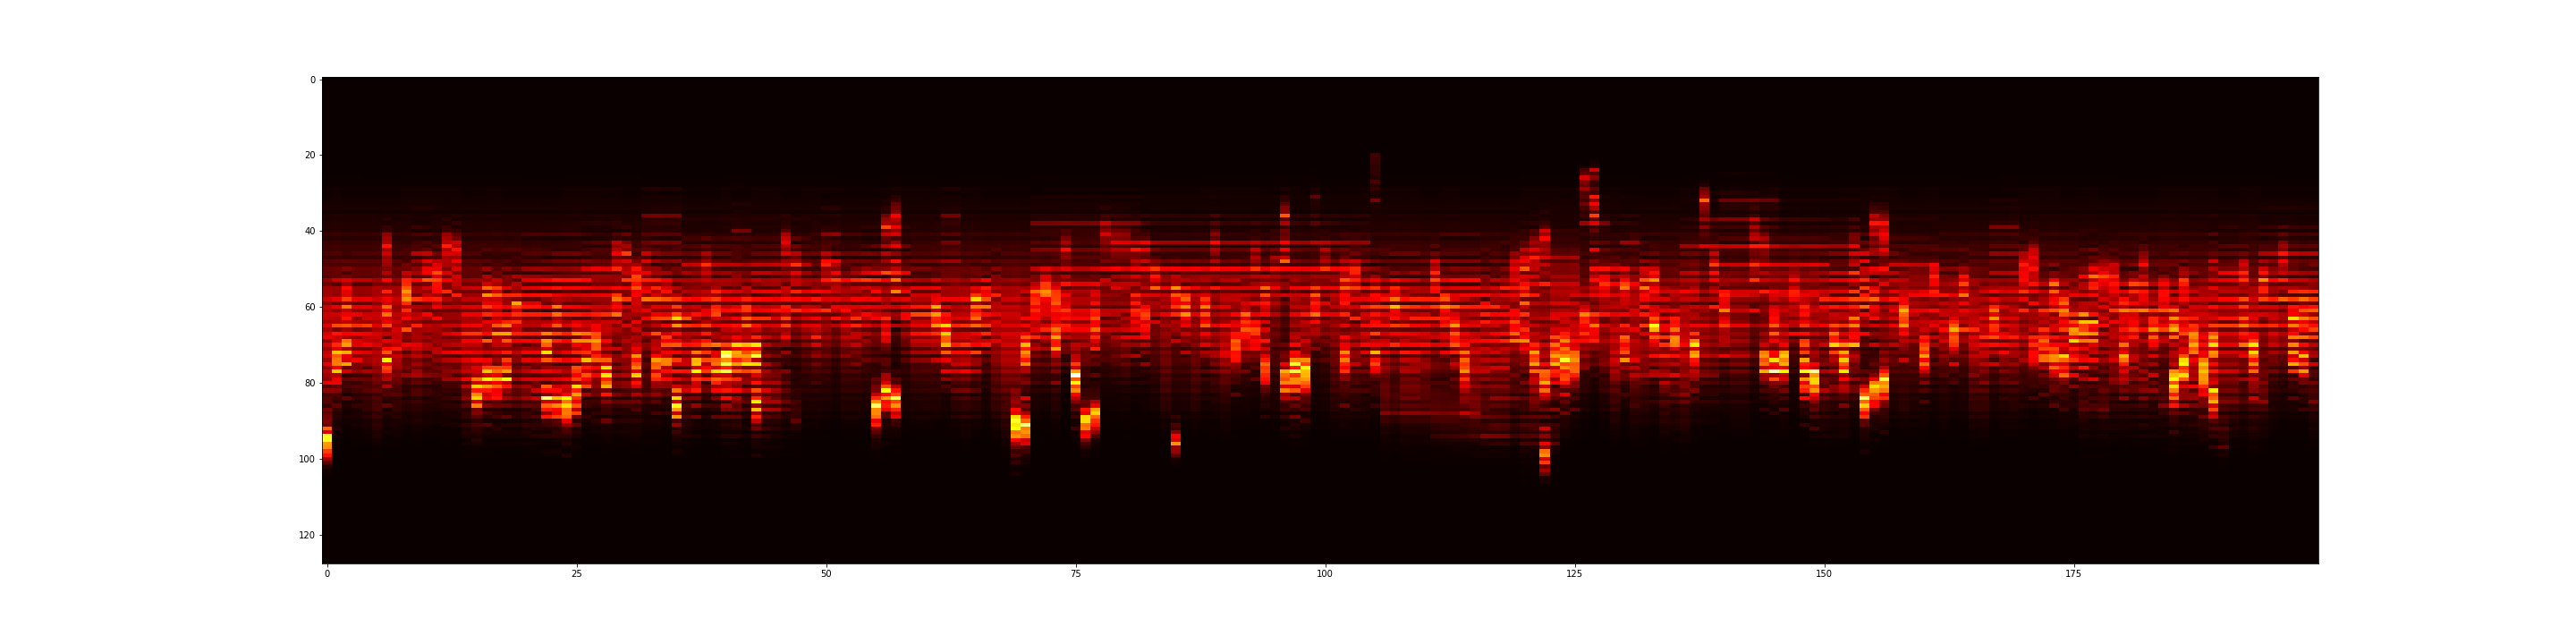

In [81]:
Image("plots/Exp8_artic__exp9_everything__probs_15_0dot0005_20_1_20_128_63_48_300__12-21-2021_22-30-33.png")

In [12]:
!ls audio/RNNMusicExperimentFive_music_15_0dot01_3_1_1_128_312-21-2021_03-33-11.wav

audio/RNNMusicExperimentFive_music_15_0dot01_3_1_1_128_312-21-2021_03-33-11.wav


## Evaluation of Different Models

In [15]:
histories = []
history_labels = []
parameter = "loss"

histories.append(exp1.get_history())
# histories.append(exp2.get_history())
# histories.append(exp3.get_history())
histories.append(exp4.get_history())
histories.append(exp5.get_history())
histories.append(exp6.get_history())

history_labels.append("exp1")
# history_labels.append("exp2")
# history_labels.append("exp3")
history_labels.append("exp4")
history_labels.append("exp5")
history_labels.append("exp6")

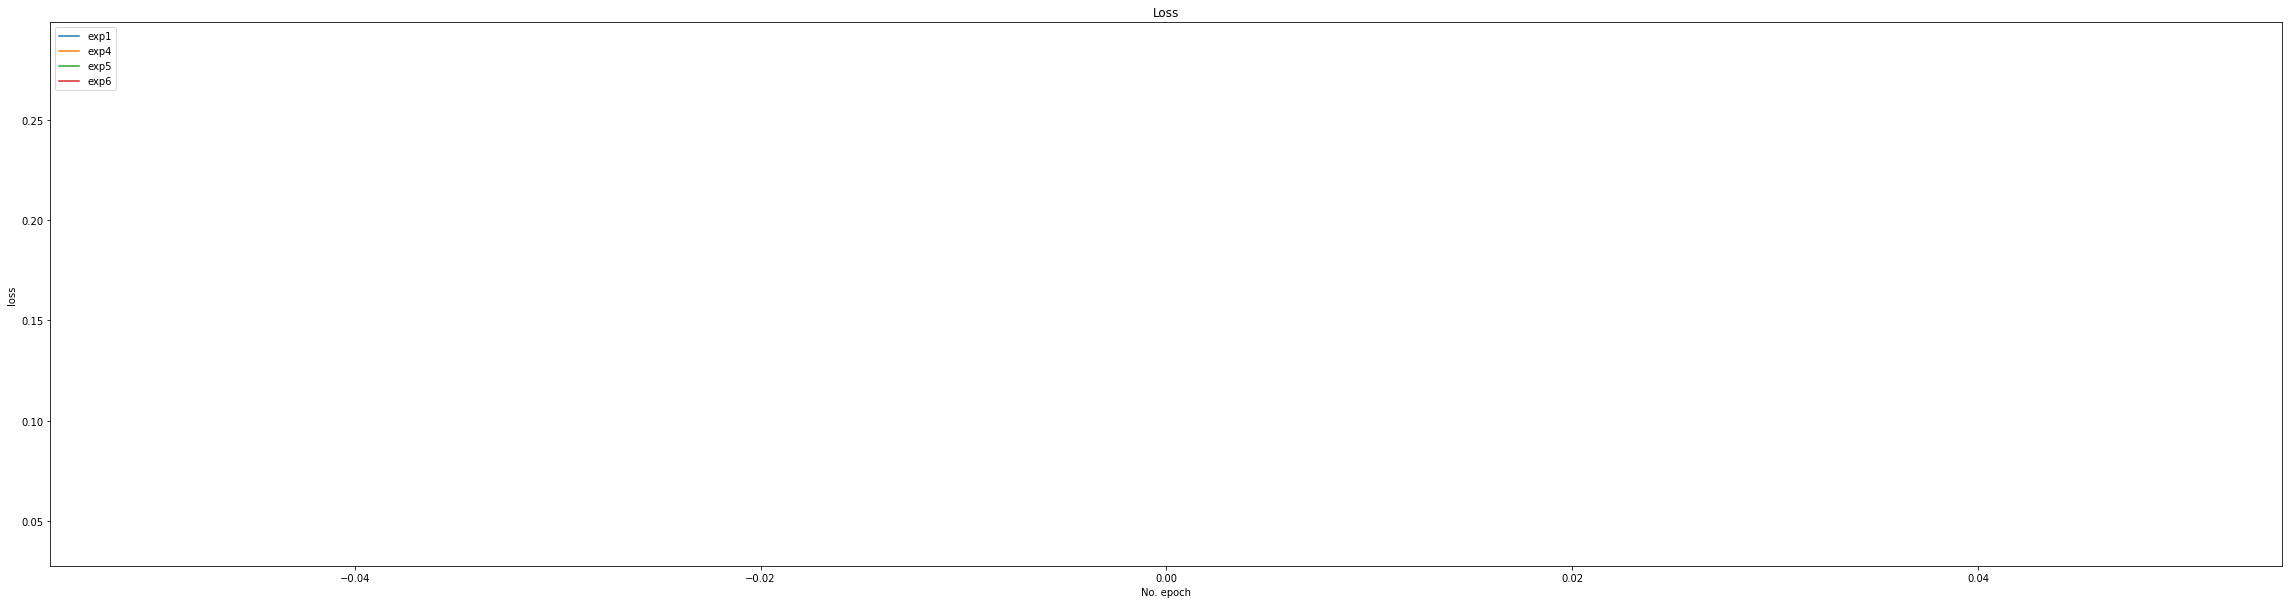

In [16]:
plot_histories(histories, history_labels, parameter)

In [ ]:
#TODO: Predict 30s with each experiment
#TODO: Implement function for RNNExperiment to turn prediction into midi_file
#TODO: Write getter function for output pretty midi of RNNExperiment
#TODO: Plot graph with all models
#TODO: Have predicted music files from each (optional)
#TODO: Write paragraph about what effect each change has